In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import astropy.constants as c
from astropy.timeseries import LombScargle
from astropy.modeling import models, fitting
import pandas as pd


%matplotlib inline

In [2]:
# Define row headings
row_headings = ["Orbital Frequency (days⁻¹)", "Orbital Period (hours)", "Spin Frequency (days⁻¹)", "Spin Period (seconds)", "Model Spin Period (seconds)", "Model Spin Period Error (seconds)", "Model Spin Period Reduced χ2"]

# Create an empty DataFrame with NaNs
data = pd.DataFrame(np.nan, index=row_headings, columns=range(0, 8))

data.columns = ['0: Sector7', '1: Sector71', '2: Sector72', '3: Sector71', '4: Sector72', '5: Sector7', '6: Sector71', '7: Sector72']

## BG Canis Minoris 0

In [3]:
lc0 = np.genfromtxt("bgcmi0.csv", delimiter=",")
time0 = lc0[0]
flux0 = lc0[1]
flux_error0 = lc0[2]

(1495.0, 1496.0)

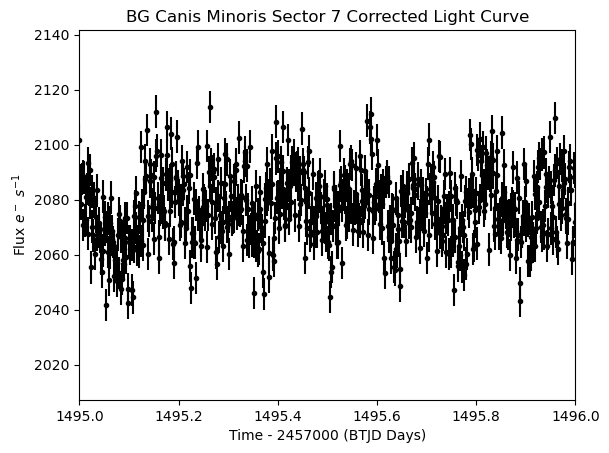

In [4]:
plt.errorbar(time0, flux0, yerr=flux_error0, fmt='k.')
plt.title('BG Canis Minoris Sector 7 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(1495, 1496)

Text(189, 0.01, '2$\\omega$')

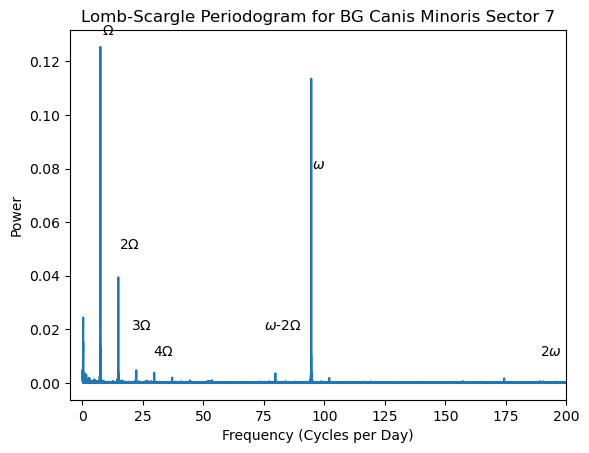

In [5]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies01 = np.linspace(min_freq, max_freq, 1000000) 

power01 = LombScargle(time0, flux0).power(frequencies01)

plt.plot(frequencies01, power01)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 7')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.13, '$\Omega$')
plt.text(95, 0.08, '$\omega$')
plt.text(15, 0.05, '2$\Omega$')
plt.text(20, 0.02, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [6]:
forb0 = frequencies01[np.argmax(power01)]
print(forb0)

porb0 = 1/forb0
porb0h = porb0*u.day.to(u.hour)
print(porb0h)

min_freq = 50  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency
frequencies02 = np.linspace(min_freq, max_freq, 1000000) 
power02 = LombScargle(time0, flux0).power(frequencies02)


fspin0 = frequencies02[np.argmax(power02)]
print(fspin0)

pspin0 = 1/fspin0
pspin0s = pspin0*u.day.to(u.s)
print(pspin0s)

7.421539558311121
3.233830367867978
94.58485637851938
913.465466969


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

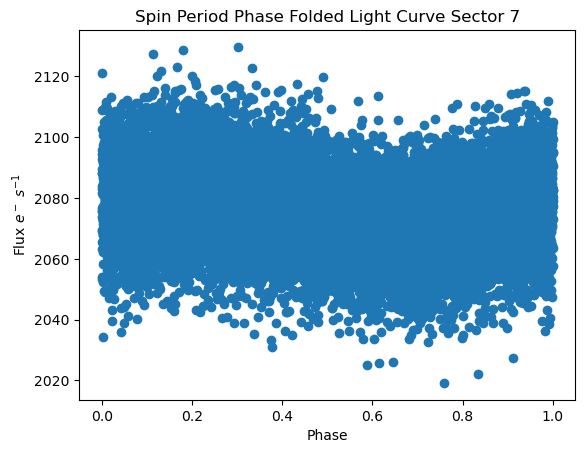

In [7]:
t0 = time0[0]

# Compute cycle number
n0 = (time0 - t0) / pspin0

# Compute new x-axis (integer cycles + phase)
spin_folded0 = (n0 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded0)
spin_folded_sorted0 = spin_folded0[sorted_indices]
spin_flux_sorted0 = flux0[sorted_indices]

plt.scatter(spin_folded_sorted0, spin_flux_sorted0)
plt.title('Spin Period Phase Folded Light Curve Sector 7')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 9.913e-01  4.055e+00 ... -1.049e+00 -8.686e-01]
           x: [ 5.807e+00  7.421e+00  2.043e-01  3.633e+00  2.076e+03]
        cost: 35837.24961253873
         jac: [[ 6.248e-02  1.234e+04 ...  1.421e-01  1.607e-01]
               [ 7.226e-02  1.102e+04 ...  1.513e-01  1.614e-01]
               ...
               [-1.066e-01 -7.789e+03 ...  1.722e-01  1.724e-01]
               [-1.155e-01 -8.780e+03 ...  1.701e-01  1.729e-01]]
        grad: [-2.163e+02 -3.690e+07 -1.530e+04  1.442e+02  1.409e+00]
  optimality: 36896502.89368668
 active_mask: [0 0 0 0 0]
        nfev: 34
        njev: None
   param_cov: [[ 4.288e-03 -2.373e-10 ...  3.251e-06 -4.467e-07]
               [-2.373e-10  7.932e-12 ...  2.711e-11 -1.493e-10]
               ...
               [ 3.251e-06  2.711e-11 ...  4.290e-03  4.005e-06]
               [-4.467e-07 -1.493e-10 ...  4.005e-06  2.146e-03]]
4.49708239585126

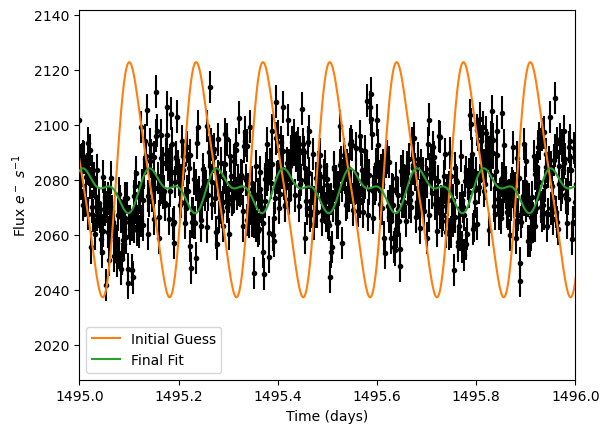

In [8]:
sine01 = models.Sine1D(amplitude=40, frequency=7.421539558311121, phase=0.25)
sine02 = models.Sine1D(amplitude=8, frequency=2*7.421539558311121, phase=0.5)
constant0 = models.Const1D(amplitude=2080)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb0 = sine01 + sine02 + constant0

def tie_freq(model):
    return model.frequency_0 * 2

sine02.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine02.phase.tied = tie_phase

sin_final_orb0 = fit_sin(sin_init_orb0, time0, flux0, weights=1/flux_error0, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb0 = np.sum(((sin_final_orb0(time0)-flux0)/flux_error0)**2)
chi2_r_orb0 = chi2_orb0/(len(time0)-3)
print(chi2_r_orb0)

pfit_orb0 = fit_sin.fit_info.x
pcov_orb0 = fit_sin.fit_info.param_cov * chi2_r_orb0
print(pcov_orb0)
error_orb0 = []

for i in range(len(pfit_orb0)):
    error_orb0.append(np.absolute(pcov_orb0[i][i])**0.5)
        
perr_leastsq_orb0 = np.array(error_orb0) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb0)
print("perr = \ ", perr_leastsq_orb0)

plt.errorbar(time0, flux0 ,flux_error0 ,fmt='k.', zorder=1),
plt.plot(time0 ,sin_init_orb0(time0),'C1', label='Initial Guess', zorder=2)
plt.plot(time0 ,sin_final_orb0(time0),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(1495,1496)
plt.legend()
plt.show()

#+models.Sine1D(amplitude=1, frequency=29, phase=0.5)
#+models.Sine1D(amplitude=2, frequency=22.26, phase=0.5)

In [9]:
BIC = -2*np.log(chi2_orb0)+10*np.log(len(time0))

print(chi2_orb0)
print(BIC)

71674.49922507745
74.40671624837144


In [10]:
residual0 = flux0-sin_final_orb0(time0)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 7')

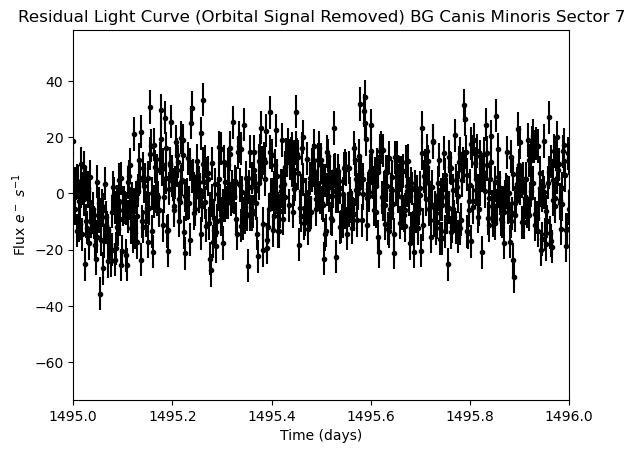

In [11]:
plt.errorbar(time0, residual0, yerr=flux_error0, fmt='k.')
plt.xlim(1495, 1496)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 7')

(-5.0, 200.0)

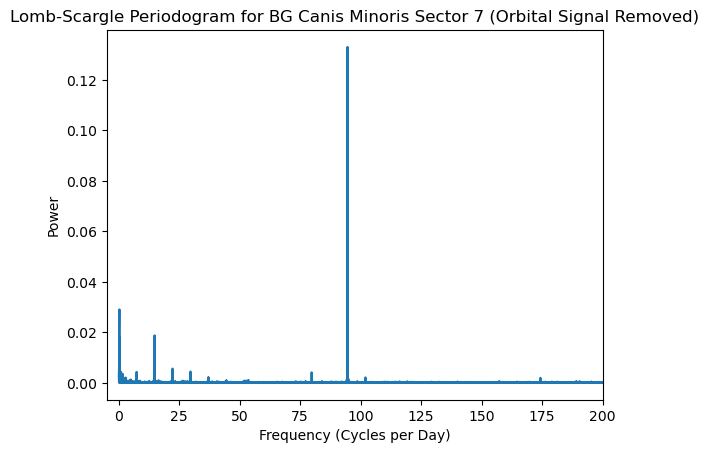

In [12]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies03 = np.linspace(min_freq, max_freq, 1000000) 

power03 = LombScargle(time0, residual0).power(frequencies03)

plt.plot(frequencies03, power03)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 7 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

C:\Users\aisli\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aisli\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

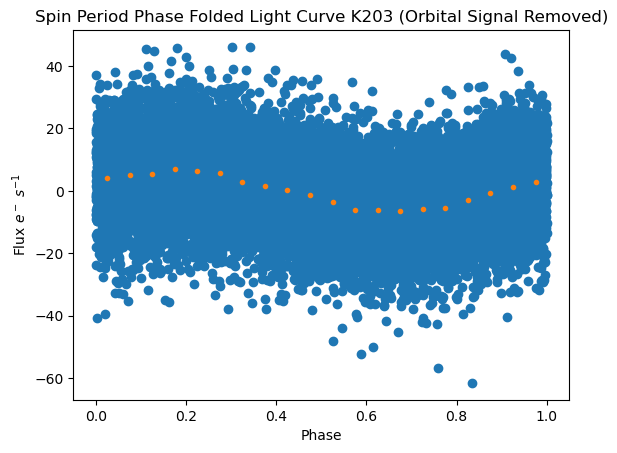

In [13]:
t0 = time0[0]

# Compute cycle number
n0 = (time0 - t0) / pspin0

# Compute new x-axis (integer cycles + phase)
spin_folded0 = (n0 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded0)
spin_folded_sorted0 = spin_folded0[sorted_indices]
spin_flux_sorted0 = residual0[sorted_indices]

dphase = 0.05
temp_phase= np.arange(0,1.001,dphase)

for i,phi_i in enumerate(temp_phase):
    phase_filt = np.where((spin_folded_sorted0>=phi_i) & (spin_folded_sorted0<(phi_i+dphase)))
    median_phase = np.median(spin_folded_sorted0[phase_filt])
    median_flux = np.median(spin_flux_sorted0[phase_filt])
    
    plt.plot(median_phase,median_flux,'C1.')

plt.scatter(spin_folded_sorted0, spin_flux_sorted0)
plt.title('Spin Period Phase Folded Light Curve K203 (Orbital Signal Removed)')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')
#plt.ylim(42000,58000)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.095e+00  4.274e+00 ... -8.637e-01 -8.576e-01]
           x: [ 1.409e+00  9.459e+01 -7.729e-01]
        cost: 33970.398383102394
         jac: [[ 7.337e-02  1.888e+03  1.265e+00]
               [ 1.555e-01  5.709e+02  3.827e-01]
               ...
               [ 1.318e-01 -1.490e+03 -9.831e-01]
               [ 7.829e-03 -2.317e+03 -1.528e+00]]
        grad: [-1.161e+03 -1.056e+03 -2.279e+00]
  optimality: 1161.1120945152213
 active_mask: [0 0 0]
        nfev: 27
        njev: 8
   param_cov: [[ 4.290e-03 -2.466e-08  3.716e-05]
               [-2.466e-08  1.031e-06 -1.551e-03]
               [ 3.716e-05 -1.551e-03  2.334e+00]]
4.262818218484426
[[ 1.82894973e-02 -1.05134445e-07  1.58410074e-04]
 [-1.05134445e-07  4.39701794e-06 -6.61349981e-03]
 [ 1.58410074e-04 -6.61349981e-03  9.94751610e+00]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [ 1.40865418 

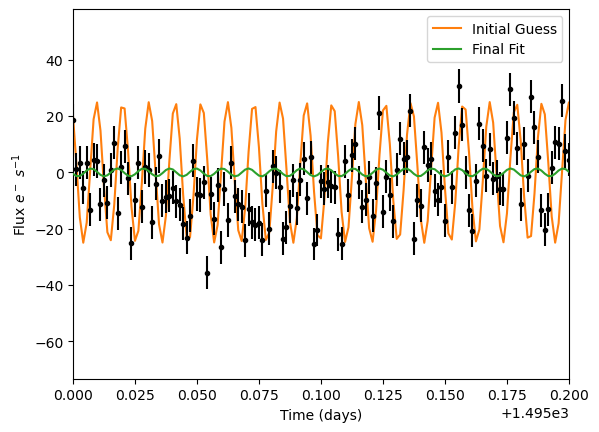

In [14]:
sine01 = models.Sine1D(amplitude=25, frequency=94.58485637851938, phase=0)
sine02 = models.Sine1D(amplitude=5, frequency=94.58485637851938-2*7.421539558311121, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin0 = sine01 #+ sine02

def tie_freq(model):
    return model.frequency_0 - 2*7.421539558311121

sine02.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine02.phase.tied = tie_phase

sin_final_spin0 = fit_sin(sin_init_spin0, time0, residual0, weights=1/flux_error0, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin0 = np.sum(((sin_final_spin0(time0)-residual0)/flux_error0)**2)
chi2_r_spin0 = chi2_spin0/(len(time0)-3)
print(chi2_r_spin0)

pfit_spin0 = fit_sin.fit_info.x
pcov_spin0 = fit_sin.fit_info.param_cov * chi2_r_spin0
print(pcov_spin0)
error_spin0 = []

for i in range(len(pfit_spin0)):
    error_spin0.append(np.absolute(pcov_spin0[i][i])**0.5)
        
perr_leastsq_spin0 = np.array(error_spin0) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin0)
print("perr = \ ", perr_leastsq_spin0)

plt.errorbar(time0, residual0, flux_error0, fmt='k.', zorder=2),
plt.plot(time0, sin_init_spin0(time0),'C1', label='Initial Guess', zorder=1)
plt.plot(time0, sin_final_spin0(time0),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(1495, 1495.2)
plt.show()

In [15]:
pspin0_model = 1/pfit_spin0[1]
pspin0_models = pspin0_model*u.day.to(u.s)

pspin0_model_error = (1/pfit_spin0[1])*(perr_leastsq_spin0[1])
pspin0_model_errors = pspin0_model_error*u.day.to(u.s)

print(pspin0_models)
print(pspin0_model_errors)

913.4591291155442
1.9154386191760873


## BG Canis Minoris 1

In [16]:
lc1 = np.genfromtxt("bgcmi1.csv", delimiter=",")
time1 = lc1[0]
flux1 = lc1[1]
flux_error1 = lc1[2]

(3236.0, 3237.0)

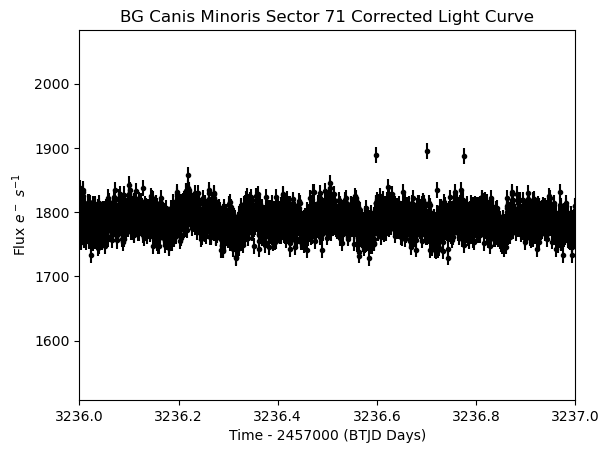

In [17]:
plt.errorbar(time1, flux1, yerr=flux_error1, fmt='k.')
plt.title('BG Canis Minoris Sector 71 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3236, 3237)

Text(189, 0.01, '2$\\omega$')

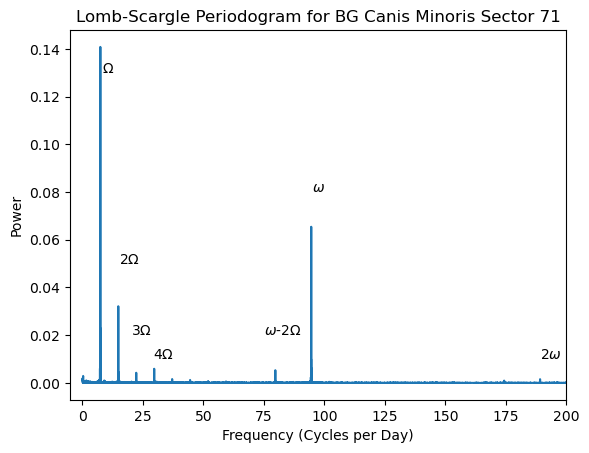

In [18]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time1)))  # Nyquist frequency

frequencies11 = np.linspace(min_freq, max_freq, 1000000) 

power11 = LombScargle(time1, flux1).power(frequencies11)

plt.plot(frequencies11, power11)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.13, '$\Omega$')
plt.text(95, 0.08, '$\omega$')
plt.text(15, 0.05, '2$\Omega$')
plt.text(20, 0.02, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [19]:
forb1 = frequencies11[np.argmax(power11)]
print(forb1)

porb1 = 1/forb1
porb1h = porb1*u.day.to(u.hour)
print(porb1h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time1)))  # Nyquist frequency
frequencies12 = np.linspace(min_freq, max_freq, 1000000) 
power12 = LombScargle(time1, flux1).power(frequencies12)


fspin1 = frequencies12[np.argmax(power12)]
print(fspin1)

pspin1 = 1/fspin1
pspin1s = pspin1*u.day.to(u.s)
print(pspin1s)

7.421371927551807
3.233903412238392
94.58457981362223
913.4681379380249


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

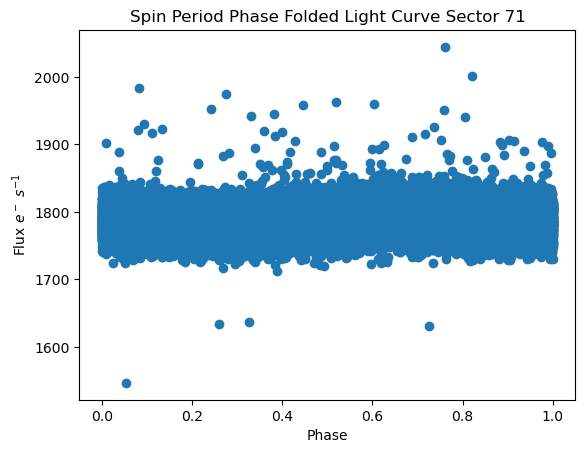

In [20]:
t1 = time1[0]

# Compute cycle number
n1 = (time1 - t1) / pspin1

# Compute new x-axis (integer cycles + phase)
spin_folded1 = (n1 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded1)
spin_folded_sorted1 = spin_folded1[sorted_indices]
spin_flux_sorted1 = flux1[sorted_indices]

plt.scatter(spin_folded_sorted1, spin_flux_sorted1)
plt.title('Spin Period Phase Folded Light Curve Sector 71')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 4.782e-01  3.791e-01 ...  2.276e-01 -2.911e-01]
           x: [ 1.153e+00  7.443e+00  2.530e+00 -3.917e+00  1.788e+03]
        cost: 89206.72400273055
         jac: [[-2.071e-02  5.745e+03 ... -5.549e-02  7.532e-02]
               [-1.985e-02  5.626e+03 ... -5.636e-02  7.503e-02]
               ...
               [-5.961e-02 -7.085e+03 ...  7.828e-03  7.430e-02]
               [-5.954e-02 -6.992e+03 ...  9.340e-03  7.363e-02]]
        grad: [-5.730e+02  1.041e+07  4.673e+03 -1.001e+03  1.552e+00]
  optimality: 10406047.463843383
 active_mask: [0 0 0 0 0]
        nfev: 75
        njev: None
   param_cov: [[ 3.599e-03  5.987e-10 ... -7.106e-07 -7.249e-07]
               [ 5.987e-10  2.088e-10 ...  4.274e-10 -1.208e-09]
               ...
               [-7.106e-07  4.274e-10 ...  3.588e-03  9.099e-06]
               [-7.249e-07 -1.208e-09 ...  9.099e-06  1.795e-03]]
2.0956779665640

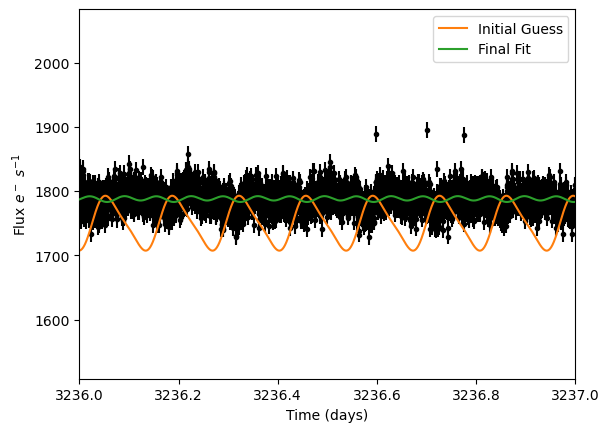

In [21]:
sine11 = models.Sine1D(amplitude=40, frequency=7.421371927551807, phase=0.25)
sine12 = models.Sine1D(amplitude=8, frequency=2*7.421371927551807, phase=0.5)
constant1 = models.Const1D(amplitude=1750)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb1 = sine11 + sine12 + constant1

def tie_freq(model):
    return model.frequency_0 * 2

sine12.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine12.phase.tied = tie_phase

sin_final_orb1 = fit_sin(sin_init_orb1, time1, flux1, weights=1/flux_error1, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb1 = np.sum(((sin_final_orb1(time1)-flux1)/flux_error1)**2)
chi2_r_orb1 = chi2_orb1/(len(time1)-3)
print(chi2_r_orb1)

pfit_orb1 = fit_sin.fit_info.x
pcov_orb1 = fit_sin.fit_info.param_cov * chi2_r_orb1
print(pcov_orb1)
error_orb1 = []

for i in range(len(pfit_orb1)):
    error_orb1.append(np.absolute(pcov_orb1[i][i])**0.5)
        
perr_leastsq_orb1 = np.array(error_orb1) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb1)
print("perr = \ ", perr_leastsq_orb1)

plt.errorbar(time1, flux1, flux_error1, fmt='k.', zorder=1),
plt.plot(time1 ,sin_init_orb1(time1),'C1', label='Initial Guess', zorder=2)
plt.plot(time1 ,sin_final_orb1(time1),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3236, 3237)
plt.legend()
plt.show()

In [22]:
BIC = -2*np.log(chi2_orb1)+7*np.log(len(time1))

print(chi2_orb1)
print(BIC)

178413.4480054611
55.28040126379001


In [23]:
residual1 = flux1-sin_final_orb1(time1)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

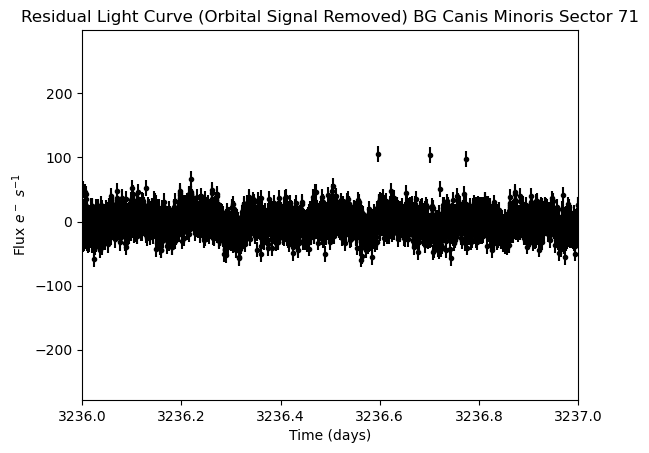

In [24]:
plt.errorbar(time1, residual1, yerr=flux_error1, fmt='k.')
plt.xlim(3236, 3237)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

(-5.0, 200.0)

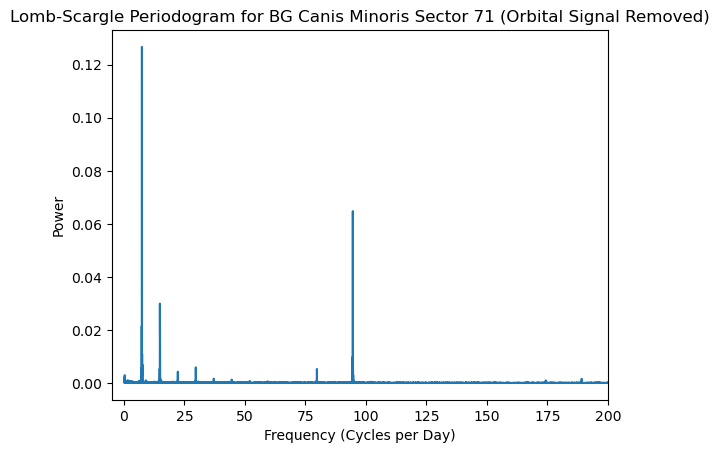

In [25]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time1)))  # Nyquist frequency

frequencies13 = np.linspace(min_freq, max_freq, 1000000) 

power13 = LombScargle(time1, residual1).power(frequencies13)

plt.plot(frequencies13, power13)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.238e-01  1.638e-01 ... -7.502e-02 -6.386e-01]
           x: [ 6.449e+00  9.459e+01 -3.295e+00]
        cost: 83416.13285386426
         jac: [[-2.394e-02 -9.364e+03 -2.894e+00]
               [-3.338e-02 -8.811e+03 -2.723e+00]
               ...
               [-4.692e-02 -7.609e+03 -2.335e+00]
               [-5.388e-02 -6.626e+03 -2.033e+00]]
        grad: [-3.960e-05  2.819e+03  8.700e-01]
  optimality: 2818.6483754809597
 active_mask: [0 0 0]
        nfev: 6
        njev: 5
   param_cov: [[ 3.591e-03 -3.425e-09  1.112e-05]
               [-3.425e-09  4.134e-08 -1.343e-04]
               [ 1.112e-05 -1.343e-04  4.360e-01]]
1.9596432178416203
[[ 7.03735695e-03 -6.71165184e-09  2.17830395e-05]
 [-6.71165184e-09  8.10154608e-08 -2.63106347e-04]
 [ 2.17830395e-05 -2.63106347e-04  8.54470200e-01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [ 6.44900489 9

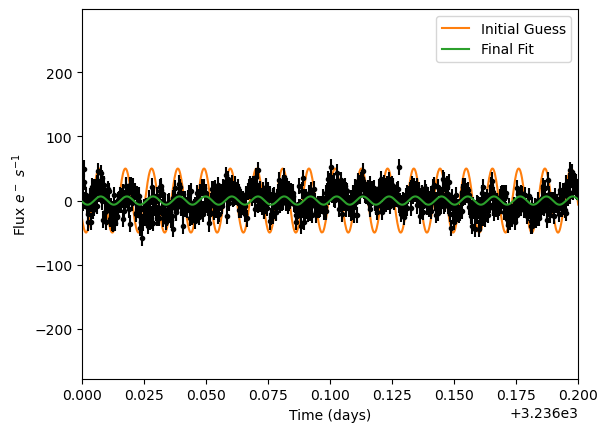

In [26]:
sine11 = models.Sine1D(amplitude=50, frequency=94.58457981362223, phase=-0.1)
sine12 = models.Sine1D(amplitude=10, frequency=94.58457981362223-2*7.421371927551807, phase=0.15)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin1 = sine11 #+ sine12

def tie_freq(model):
    return model.frequency_0 - 2*7.421371927551807

sine12.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine12.phase.tied = tie_phase

sin_final_spin1 = fit_sin(sin_init_spin1, time1, residual1, weights=1/flux_error1, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin1 = np.sum(((sin_final_spin1(time1)-residual1)/flux_error1)**2)
chi2_r_spin1 = chi2_spin1/(len(time1)-3)
print(chi2_r_spin1)

pfit_spin1 = fit_sin.fit_info.x
pcov_spin1 = fit_sin.fit_info.param_cov * chi2_r_spin1
print(pcov_spin1)
error_spin1 = []

for i in range(len(pfit_spin1)):
    error_spin1.append(np.absolute(pcov_spin1[i][i])**0.5)
        
perr_leastsq_spin1 = np.array(error_spin1) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin1)
print("perr = \ ", perr_leastsq_spin1)

plt.errorbar(time1, residual1, flux_error1, fmt='k.', zorder=2),
plt.plot(time1, sin_init_spin1(time1),'C1', label='Initial Guess', zorder=1)
plt.plot(time1, sin_final_spin1(time1),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3236, 3236.2)
plt.show()

In [27]:
pspin1_model = 1/pfit_spin1[1]
pspin1_models = pspin1_model*u.day.to(u.s)

pspin1_model_error = (1/pfit_spin1[1])*(perr_leastsq_spin1[1])
pspin1_model_errors = pspin1_model_error*u.day.to(u.s)

print(pspin1_models)
print(pspin1_model_errors)

913.4587724640764
0.25999973427033357


## BG Canis Minoris 2

In [28]:
lc2 = np.genfromtxt("bgcmi2.csv", delimiter=",")
time2 = lc2[0]
flux2 = lc2[1]
flux_error2 = lc2[2]

(3265.0, 3266.0)

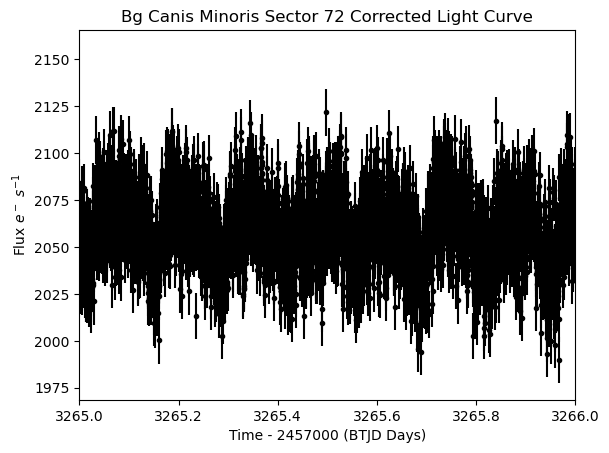

In [29]:
plt.errorbar(time2, flux2, yerr=flux_error2, fmt='k.')
plt.title('Bg Canis Minoris Sector 72 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3265, 3266)

Text(189, 0.01, '2$\\omega$')

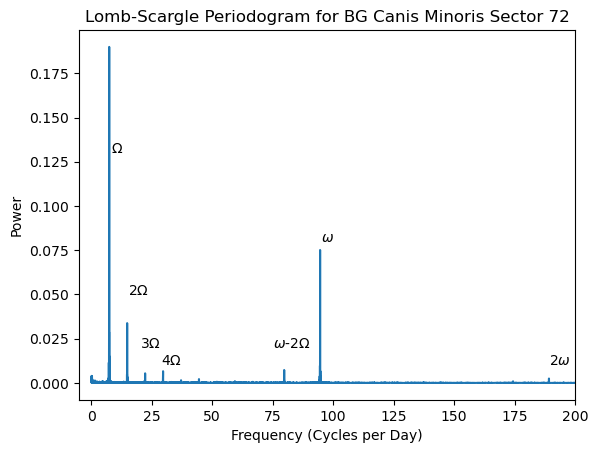

In [30]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies21 = np.linspace(min_freq, max_freq, 1000000) 

power21 = LombScargle(time2, flux2).power(frequencies21)

plt.plot(frequencies21, power21)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.13, '$\Omega$')
plt.text(95, 0.08, '$\omega$')
plt.text(15, 0.05, '2$\Omega$')
plt.text(20, 0.02, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [31]:
forb2 = frequencies21[np.argmax(power21)]
print(forb2)

porb2 = 1/forb2
porb2h = porb2*u.day.to(u.hour)
print(porb2h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency
frequencies22 = np.linspace(min_freq, max_freq, 1000000) 
power22 = LombScargle(time2, flux2).power(frequencies22)


fspin2 = frequencies22[np.argmax(power22)]
print(fspin2)

pspin2 = 1/fspin2
pspin2s = pspin2*u.day.to(u.s)
print(pspin2s)

7.421526683249744
3.2338359780026904
94.58500865581291
913.4639963337373


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

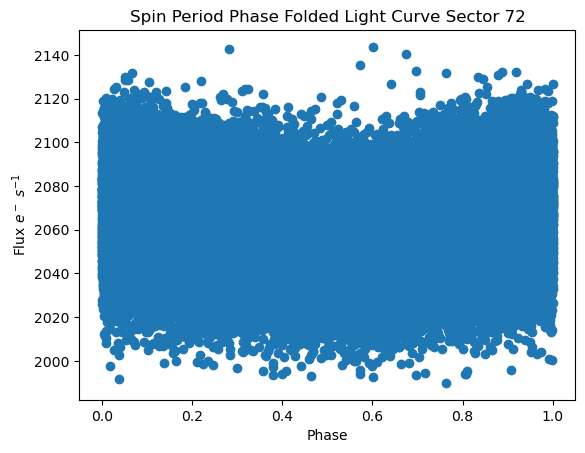

In [32]:
t2 = time2[0]

# Compute cycle number
n2 = (time2 - t2) / pspin2

# Compute new x-axis (integer cycles + phase)
spin_folded2 = (n2 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded2)
spin_folded_sorted2 = spin_folded2[sorted_indices]
spin_flux_sorted2 = flux2[sorted_indices]

plt.scatter(spin_folded_sorted2, spin_flux_sorted2)
plt.title('Spin Period Phase Folded Light Curve Sector 72')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.449e-01 -1.076e+00 ...  1.480e+00  2.250e+00]
           x: [ 8.085e+00  7.421e+00  4.493e-01 -2.038e-01  2.062e+03]
        cost: 77727.1646073682
         jac: [[ 5.658e-02  6.535e+03 ...  3.482e-02  7.394e-02]
               [ 5.707e-02  6.448e+03 ...  3.621e-02  7.391e-02]
               ...
               [ 3.391e-02 -1.043e+04 ... -6.946e-02  8.116e-02]
               [ 3.312e-02 -1.049e+04 ... -7.036e-02  8.117e-02]]
        grad: [-8.170e+02 -1.114e+08 -3.948e+04  1.191e+03  1.170e+01]
  optimality: 111350581.67145461
 active_mask: [0 0 0 0 0]
        nfev: 22
        njev: None
   param_cov: [[ 3.753e-03 -1.024e-08 ...  9.808e-06  8.056e-06]
               [-1.024e-08  6.313e-09 ...  8.617e-09 -1.316e-08]
               ...
               [ 9.808e-06  8.617e-09 ...  3.763e-03 -5.926e-06]
               [ 8.056e-06 -1.316e-08 ... -5.926e-06  1.880e-03]]
1.87237975567282

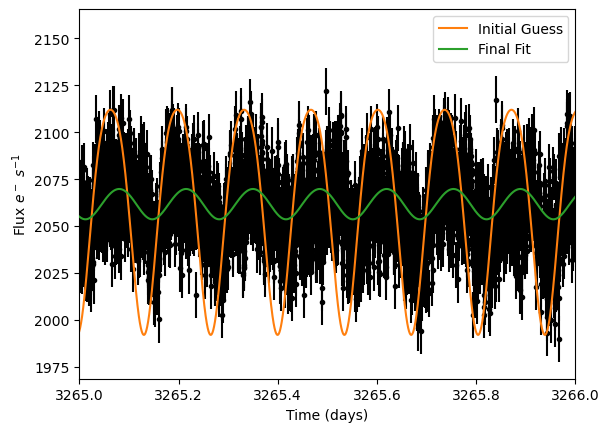

In [33]:
sine21 = models.Sine1D(amplitude=60, frequency=7.421526683249744, phase=0.5)
sine22 = models.Sine1D(amplitude=8, frequency=2*7.421526683249744, phase=0.25)
constant2 = models.Const1D(amplitude=2060)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb2 = sine21 + sine22 + constant2

def tie_freq(model):
    return model.frequency_0 * 2

sine22.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine22.phase.tied = tie_phase

sin_final_orb2 = fit_sin(sin_init_orb2, time2, flux2, weights=1/flux_error2, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb2 = np.sum(((sin_final_orb2(time2)-flux2)/flux_error2)**2)
chi2_r_orb2 = chi2_orb2/(len(time2)-3)
print(chi2_r_orb2)

pfit_orb2 = fit_sin.fit_info.x
pcov_orb2 = fit_sin.fit_info.param_cov * chi2_r_orb2
print(pcov_orb2)
error_orb2 = []

for i in range(len(pfit_orb2)):
    error_orb2.append(np.absolute(pcov_orb2[i][i])**0.5)
        
perr_leastsq_orb2 = np.array(error_orb2) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb2)
print("perr = \ ", perr_leastsq_orb2)

plt.errorbar(time2, flux2, flux_error2, fmt='k.', zorder=1),
plt.plot(time2, sin_init_orb2(time2),'C1', label='Initial Guess', zorder=2)
plt.plot(time2, sin_final_orb2(time2),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3265,3266)
plt.legend()
plt.show()

In [34]:
residual2 = flux2-sin_final_orb2(time2)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

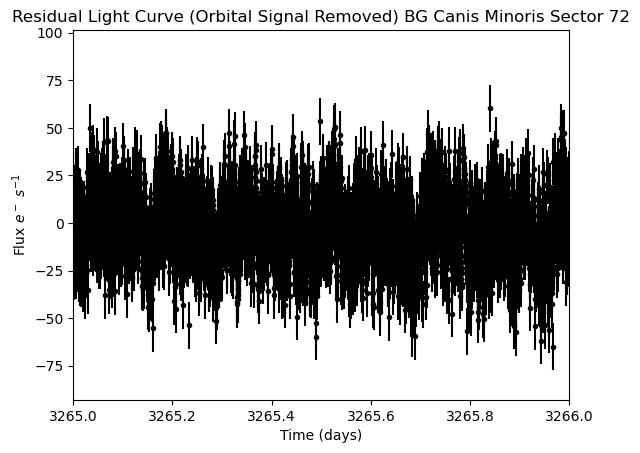

In [35]:
plt.errorbar(time2, residual2, yerr=flux_error2, fmt='k.')
plt.xlim(3265,3266)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

(-5.0, 200.0)

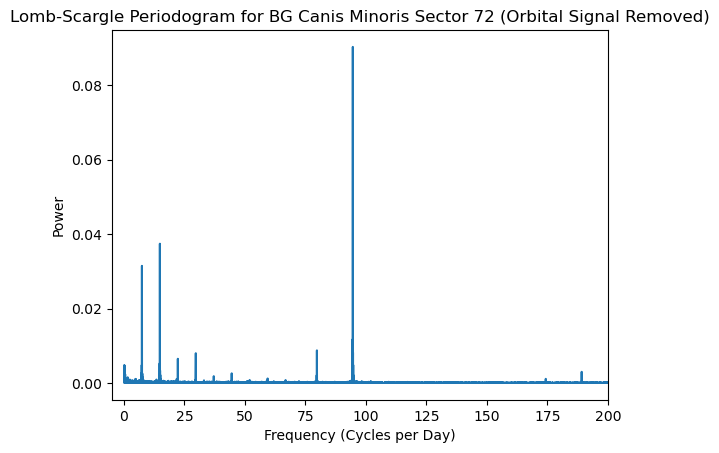

In [36]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies23 = np.linspace(min_freq, max_freq, 1000000) 

power23 = LombScargle(time2, residual2).power(frequencies23)

plt.plot(frequencies23, power23)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.788e-01 -5.399e-01 ...  1.010e+00  1.833e+00]
           x: [-7.262e+00  9.459e+01 -2.521e+00]
        cost: 70717.68867077956
         jac: [[-7.353e-02  1.166e+03  3.574e-01]
               [-7.387e-02 -3.461e+02 -1.061e-01]
               ...
               [ 6.472e-02  7.340e+03  2.234e+00]
               [ 5.741e-02  8.603e+03  2.618e+00]]
        grad: [ 4.331e-07 -1.467e+00 -4.589e-04]
  optimality: 1.4673235239024507
 active_mask: [0 0 0]
        nfev: 5
        njev: 4
   param_cov: [[ 3.762e-03 -2.265e-09  7.392e-06]
               [-2.265e-09  3.565e-08 -1.167e-04]
               [ 7.392e-06 -1.167e-04  3.822e-01]]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.788e-01 -5.399e-01 ...  1.010e+00  1.833e+00]
           x: [-7.262e+00  9.459e+01 -2.521e+00]
        cost: 70717.68867077956
         jac: [[-7.

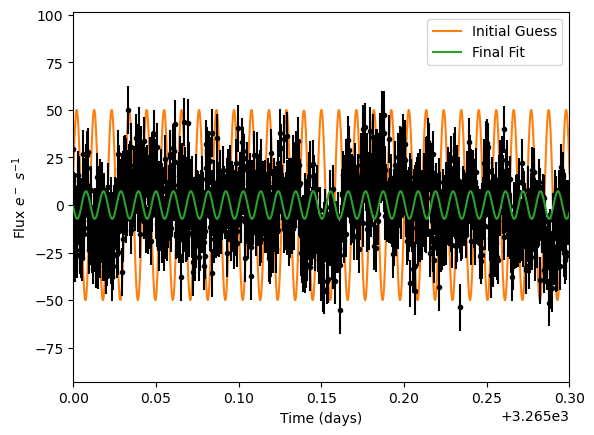

In [37]:
sine21 = models.Sine1D(amplitude=50, frequency=94.58500865581291, phase=0)
sine22 = models.Sine1D(amplitude=15, frequency=94.58500865581291-2*7.421526683249744, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin2 = sine21 #+ sine22

def tie_freq(model):
    return model.frequency_0 - 7.421526683249744

sine22.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine22.phase.tied = tie_phase

sin_final_spin2 = fit_sin(sin_init_spin2, time2, residual2, weights=1/flux_error2, maxiter=1000,acc=1e-10)
print(fit_sin.fit_info)

print(fit_sin.fit_info)

chi2_spin2 = np.sum(((sin_final_spin2(time2)-residual2)/flux_error2)**2)
chi2_r_spin2 = chi2_spin2/(len(time2)-3)
print(chi2_r_spin2)

pfit_spin2 = fit_sin.fit_info.x
pcov_spin2 = fit_sin.fit_info.param_cov * chi2_r_spin2
print(pcov_spin2)
error_spin2 = []

for i in range(len(pfit_spin2)):
    error_spin2.append(np.absolute(pcov_spin2[i][i])**0.5)
        
perr_leastsq_spin2 = np.array(error_spin2) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin2)
print("perr = \ ", perr_leastsq_spin2)

plt.errorbar(time2, residual2, flux_error2, fmt='k.', zorder=2),
plt.plot(time2, sin_init_spin2(time2),'C1', label='Initial Guess', zorder=1)
plt.plot(time2, sin_final_spin2(time2),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3265, 3265.3)
plt.show()

In [38]:
pspin2_model = 1/pfit_spin2[1]
pspin2_models = pspin2_model*u.day.to(u.s)

pspin2_model_error = (1/pfit_spin2[1])*(perr_leastsq_spin2[1])
pspin2_model_errors = pspin2_model_error*u.day.to(u.s)

print(pspin2_models)
print(pspin2_model_errors)

913.456632914418
0.22510930887827596


## BG Canis Minoris 3

In [39]:
lc3 = np.genfromtxt("bgcmi3.csv", delimiter=",")
time3 = lc3[0]
flux3 = lc3[1]
flux_error3 = lc3[2]

(3241.0, 3242.0)

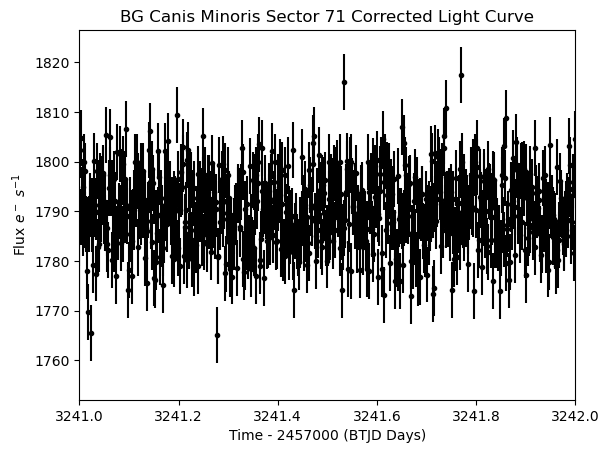

In [40]:
plt.errorbar(time3, flux3, yerr=flux_error3, fmt='k.')
plt.title('BG Canis Minoris Sector 71 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3241,3242)

Text(189, 0.001, '2$\\omega$')

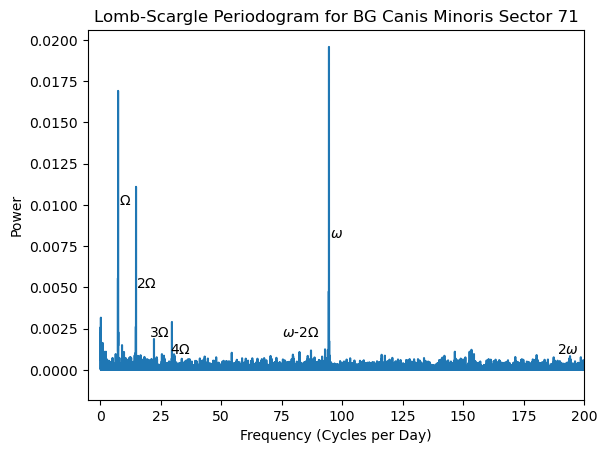

In [41]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies31 = np.linspace(min_freq, max_freq, 1000000) 

power31 = LombScargle(time3, flux3).power(frequencies31)

plt.plot(frequencies31, power31)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.01, '$\Omega$')
plt.text(95, 0.008, '$\omega$')
plt.text(15, 0.005, '2$\Omega$')
plt.text(20, 0.002, '3$\Omega$')
plt.text(29, 0.001, '4$\Omega$')
plt.text(75, 0.002, '$\omega$-2$\Omega$')
plt.text(189, 0.001,'2$\omega$' )

In [42]:
fspin3 = frequencies31[np.argmax(power31)]
print(fspin3)

pspin3 = 1/fspin3
pspin3s = pspin3*u.day.to(u.s)
print(pspin3s)

min_freq = 0.1 # Lower bound of frequencies
max_freq = 50 # Nyquist frequency
frequencies32 = np.linspace(min_freq, max_freq, 10000) 
power32 = LombScargle(time3, flux3).power(frequencies32)


forb3 = frequencies32[np.argmax(power32)]
print(forb3)

porb3 = 1/forb3
porb3h = porb3*u.day.to(u.hour)
print(porb3h)

94.58463399985799
913.4676146246941
7.421062106210621
3.2340384242189018


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

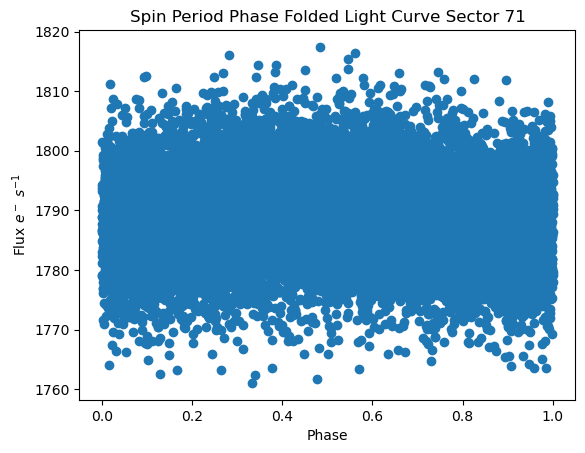

In [43]:
t3 = time3[0]

# Compute cycle number
n3 = (time3 - t3) / pspin3

# Compute new x-axis (integer cycles + phase)
spin_folded3 = (n3 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded3)
spin_folded_sorted3 = spin_folded3[sorted_indices]
spin_flux_sorted3 = flux3[sorted_indices]

plt.scatter(spin_folded_sorted3, spin_flux_sorted3)
plt.title('Spin Period Phase Folded Light Curve Sector 71')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 4.541e-01  1.268e+00 ...  1.955e-01  5.010e-01]
           x: [-1.081e+00  7.419e+00 -3.782e-01 -2.198e-01  1.483e+01
                1.789e+03]
        cost: 12743.06151810756
         jac: [[-1.013e-01  2.508e+03 ... -3.838e+02  1.661e-01]
               [-1.094e-01  2.373e+03 ... -3.688e+02  1.658e-01]
               ...
               [-1.566e-01  8.531e+02 ... -3.595e+02  1.628e-01]
               [-1.594e-01  6.584e+02 ... -3.747e+02  1.631e-01]]
        grad: [ 6.097e+01 -1.326e+06 -5.730e+02  1.329e+02 -1.741e+05
                8.620e-01]
  optimality: 1326208.560178918
 active_mask: [0 0 0 0 0 0]
        nfev: 44
        njev: None
   param_cov: [[ 4.372e-03  1.115e-07 ...  1.825e-07 -6.286e-06]
               [ 1.115e-07  4.761e-06 ...  7.815e-06 -6.740e-07]
               ...
               [ 1.825e-07  7.815e-06 ...  1.283e-05 -1.105e-06]
               [-6.286e-06 -

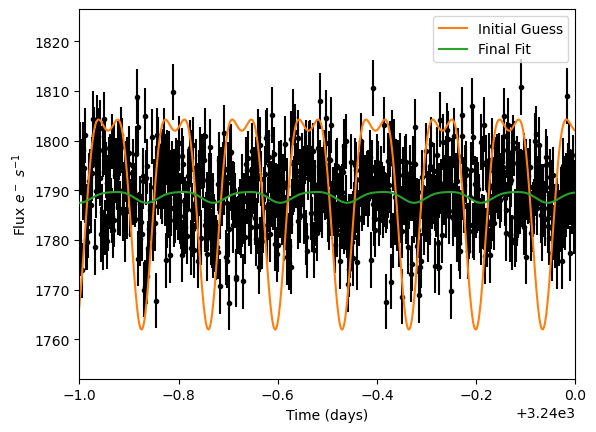

In [44]:
sine31 = models.Sine1D(amplitude=20, frequency=7.421062106210621, phase=0)
sine32 = models.Sine1D(amplitude=8, frequency=2*7.421062106210621, phase=0.25)
constant3 = models.Const1D(amplitude=1790)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb3 = sine31 + sine32 + constant3

def tie_freq(model):
    return model.frequency_0 * 2

sine22.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine32.phase.tied = tie_phase

sin_final_orb3 = fit_sin(sin_init_orb3, time3, flux3, weights=1/flux_error3, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb3 = np.sum(((sin_final_orb3(time3)-flux3)/flux_error3)**2)
chi2_r_orb3 = chi2_orb3/(len(time3)-3)
print(chi2_r_orb3)

pfit_orb3 = fit_sin.fit_info.x
pcov_orb3 = fit_sin.fit_info.param_cov * chi2_r_orb3
print(pcov_orb3)
error_orb3 = []

for i in range(len(pfit_orb3)):
    error_orb3.append(np.absolute(pcov_orb3[i][i])**0.5)
        
perr_leastsq_orb3 = np.array(error_orb3) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb3)
print("perr = \ ", perr_leastsq_orb3)

plt.errorbar(time3, flux3, flux_error3, fmt='k.', zorder=1),
plt.plot(time3, sin_init_orb3(time3),'C1', label='Initial Guess', zorder=2)
plt.plot(time3, sin_final_orb3(time3),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3239,3240)
plt.legend()
plt.show()

In [45]:
residual3 = flux3-sin_final_orb3(time3)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

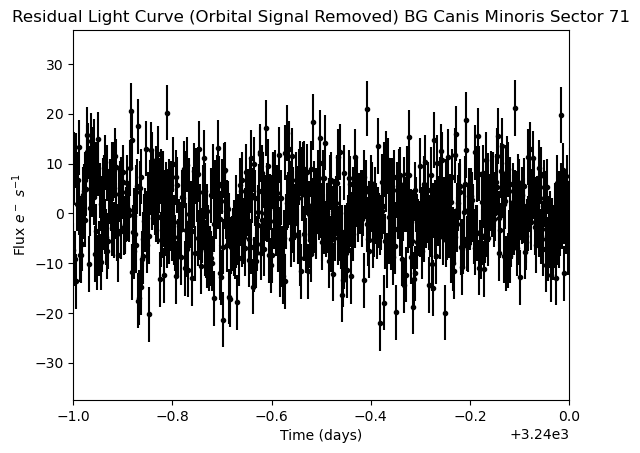

In [46]:
plt.errorbar(time3, residual3, yerr=flux_error3, fmt='k.')
plt.xlim(3239,3240)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

(-5.0, 200.0)

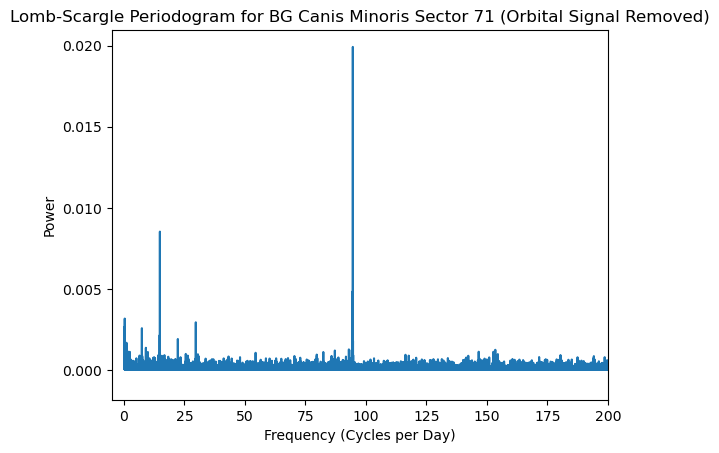

In [47]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies32 = np.linspace(min_freq, max_freq, 1000000) 

power32 = LombScargle(time3, residual3).power(frequencies32)

plt.plot(frequencies32, power32)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.207e-01  1.170e+00 ...  2.367e-01  3.531e-01]
           x: [-1.489e+00  9.458e+01 -5.253e-01]
        cost: 12489.710817385647
         jac: [[ 1.567e-01  1.666e+03  5.150e-01]
               [ 6.574e-02  4.610e+03  1.425e+00]
               ...
               [-2.768e-02 -4.894e+03 -1.501e+00]
               [ 9.931e-02 -3.947e+03 -1.211e+00]]
        grad: [ 4.829e-06 -5.129e+01 -1.572e-02]
  optimality: 51.28984019276686
 active_mask: [0 0 0]
        nfev: 5
        njev: 4
   param_cov: [[ 4.378e-03  1.179e-08 -3.833e-05]
               [ 1.179e-08  9.447e-07 -3.068e-03]
               [-3.833e-05 -3.068e-03  9.964e+00]]
1.7412116014757628
[[ 7.62360971e-03  2.05246073e-08 -6.67404538e-05]
 [ 2.05246073e-08  1.64490505e-06 -5.34198672e-03]
 [-6.67404538e-05 -5.34198672e-03  1.73487007e+01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [-1.48946598 9

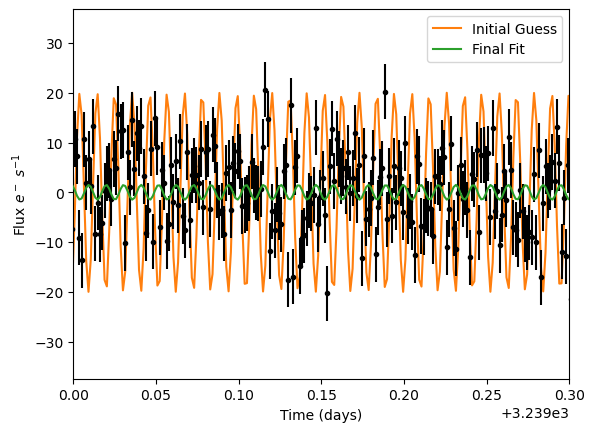

In [48]:
sine31 = models.Sine1D(amplitude=20, frequency=94.58463399985799, phase=0.25)
sine32 = models.Sine1D(amplitude=1, frequency=94.58463399985799-2*7.421062106210621, phase=0.5)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin3 = sine31 #+ sine32

def tie_freq(model):
    return model.frequency_0 - 2*7.421062106210621

sine32.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine32.phase.tied = tie_phase

sin_final_spin3 = fit_sin(sin_init_spin3, time3, residual3, weights=1/flux_error3, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin3 = np.sum(((sin_final_spin3(time3)-residual3)/flux_error3)**2)
chi2_r_spin3 = chi2_spin3/(len(time3)-3)
print(chi2_r_spin3)

pfit_spin3 = fit_sin.fit_info.x
pcov_spin3 = fit_sin.fit_info.param_cov * chi2_r_spin3
print(pcov_spin3)
error_spin3 = []

for i in range(len(pfit_spin3)):
    error_spin3.append(np.absolute(pcov_spin3[i][i])**0.5)
        
perr_leastsq_spin3 = np.array(error_spin3) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin3)
print("perr = \ ", perr_leastsq_spin3)

plt.errorbar(time3, residual3, flux_error3, fmt='k.', zorder=2),
plt.plot(time3, sin_init_spin3(time3),'C1', label='Initial Guess', zorder=1)
plt.plot(time3, sin_final_spin3(time3),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3239, 3239.3)
plt.show()

In [49]:
pspin3_model = 1/pfit_spin3[1]
pspin3_models = pspin3_model*u.day.to(u.s)

pspin3_model_error = (1/pfit_spin3[1])*(perr_leastsq_spin3[1])
pspin3_model_errors = pspin3_model_error*u.day.to(u.s)

print(pspin3_models)
print(pspin3_model_errors)

913.4653502264094
1.171554494856392


## BG Canis Minoris 4

In [50]:
lc4 = np.genfromtxt("bgcmi4.csv", delimiter=",")
time4 = lc4[0]
flux4 = lc4[1]
flux_error4 = lc4[2]

(3270.0, 3271.0)

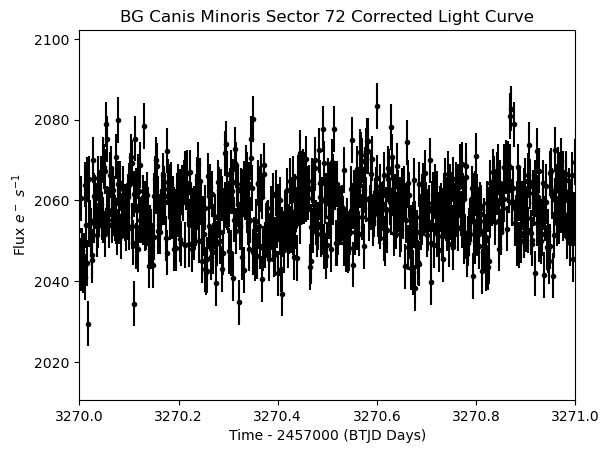

In [51]:
plt.errorbar(time4, flux4, yerr=flux_error4, fmt='k.')
plt.title('BG Canis Minoris Sector 72 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3270, 3271)

Text(189, 0.01, '2$\\omega$')

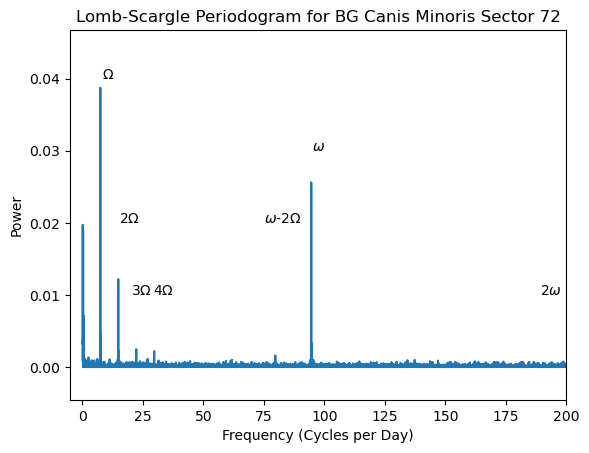

In [52]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies41 = np.linspace(min_freq, max_freq, 1000000) 

power41 = LombScargle(time4, flux4).power(frequencies41)

plt.plot(frequencies41, power41)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.04, '$\Omega$')
plt.text(95, 0.03, '$\omega$')
plt.text(15, 0.02, '2$\Omega$')
plt.text(20, 0.01, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [53]:
min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time4)))  # Nyquist frequency
frequencies42 = np.linspace(min_freq, max_freq, 1000000) 
power42 = LombScargle(time4, flux4).power(frequencies42)

fspin4 = frequencies42[np.argmax(power42)]
print(fspin4)

pspin4 = 1/fspin4
pspin4s = pspin4*u.day.to(u.s)
print(pspin4s)

min_freq = 0.01  # Lower bound of frequencies
max_freq = 50
frequencies43 = np.linspace(min_freq, max_freq, 1000000) 
power43 = LombScargle(time4, flux4).power(frequencies43)

forb4 = frequencies43[np.argmax(power43)]
print(forb4)

porb4 = 1/forb4
porb4h = porb4*u.day.to(u.hour)
print(porb4h)

94.58624350737058
913.4520707894201
7.42092493092493
3.2340982051961933


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

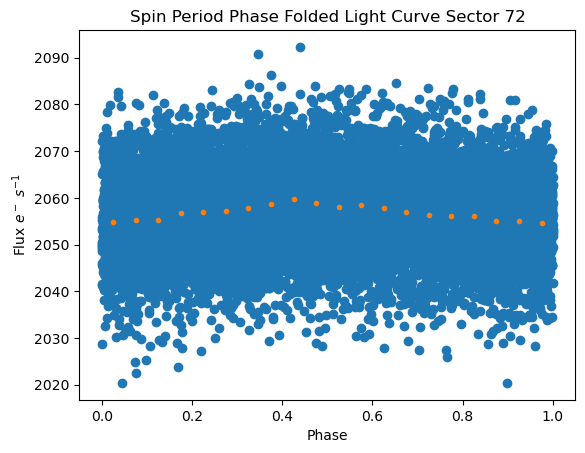

In [54]:
t4 = time4[0]

# Compute cycle number
n4 = (time4 - t4) / pspin4

# Compute new x-axis (integer cycles + phase)
spin_folded4 = (n4 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded4)
spin_folded_sorted4 = spin_folded4[sorted_indices]
spin_flux_sorted4 = flux4[sorted_indices]


dphase = 0.05
temp_phase= np.arange(0,1.001,dphase)

for i,phi_i in enumerate(temp_phase):
    phase_filt = np.where((spin_folded_sorted4>=phi_i) & (spin_folded_sorted4<(phi_i+dphase)))
    median_phase = np.median(spin_folded_sorted4[phase_filt])
    median_flux = np.median(spin_flux_sorted4[phase_filt])
    
    plt.plot(median_phase,median_flux,'C1.')
    

plt.scatter(spin_folded_sorted4, spin_flux_sorted4)
plt.title('Spin Period Phase Folded Light Curve Sector 72')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')
#plt.ylim(2054,2060)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.537e+00  1.080e+00 ... -8.354e-01  7.318e-01]
           x: [-2.283e+00  7.421e+00  4.403e-02 -4.280e-01  2.057e+03]
        cost: 15806.222199380865
         jac: [[-1.481e-01  4.098e+03 ... -6.874e-02  1.629e-01]
               [-1.522e-01  3.612e+03 ... -8.723e-02  1.629e-01]
               ...
               [-7.830e-02 -8.030e+03 ...  6.708e-02  1.784e-01]
               [-6.801e-02 -8.159e+03 ...  8.819e-02  1.791e-01]]
        grad: [ 1.202e+01 -4.513e+06 -1.626e+03 -3.809e+02  1.009e+00]
  optimality: 4512825.099777105
 active_mask: [0 0 0 0 0]
        nfev: 32
        njev: None
   param_cov: [[ 4.588e-03 -8.509e-09 ...  4.322e-06 -1.053e-05]
               [-8.509e-09  1.963e-09 ... -3.080e-09  5.560e-10]
               ...
               [ 4.322e-06 -3.080e-09 ...  4.596e-03  8.447e-06]
               [-1.053e-05  5.560e-10 ...  8.447e-06  2.298e-03]]
2.2635288843449

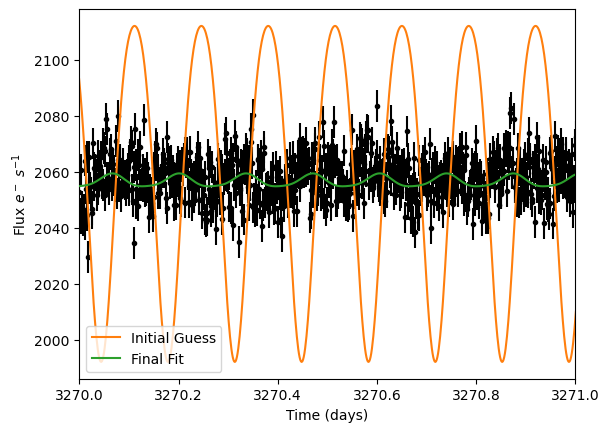

In [55]:
sine41 = models.Sine1D(amplitude=60, frequency=7.42092493092493, phase=0)
sine42 = models.Sine1D(amplitude=8, frequency=2*7.42092493092493, phase=0.25)
constant4 = models.Const1D(amplitude=2060)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb4 = sine41 + sine42 + constant4

def tie_freq(model):
    return model.frequency_0 * 2

sine42.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine42.phase.tied = tie_phase

sin_final_orb4 = fit_sin(sin_init_orb4, time4, flux4, weights=1/flux_error4, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb4 = np.sum(((sin_final_orb4(time4)-flux4)/flux_error4)**2)
chi2_r_orb4 = chi2_orb4/(len(time4)-3)
print(chi2_r_orb4)

pfit_orb4 = fit_sin.fit_info.x
pcov_orb4 = fit_sin.fit_info.param_cov * chi2_r_orb4
print(pcov_orb4)
error_orb4 = []

for i in range(len(pfit_orb4)):
    error_orb4.append(np.absolute(pcov_orb4[i][i])**0.5)
        
perr_leastsq_orb4 = np.array(error_orb4) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb4)
print("perr = \ ", perr_leastsq_orb4)

plt.errorbar(time4, flux4, flux_error4, fmt='k.', zorder=1),
plt.plot(time4, sin_init_orb4(time4),'C1', label='Initial Guess', zorder=2)
plt.plot(time4, sin_final_orb4(time4),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3270,3271)
plt.legend()
plt.show()

In [56]:
residual4 = flux4-sin_final_orb4(time4)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

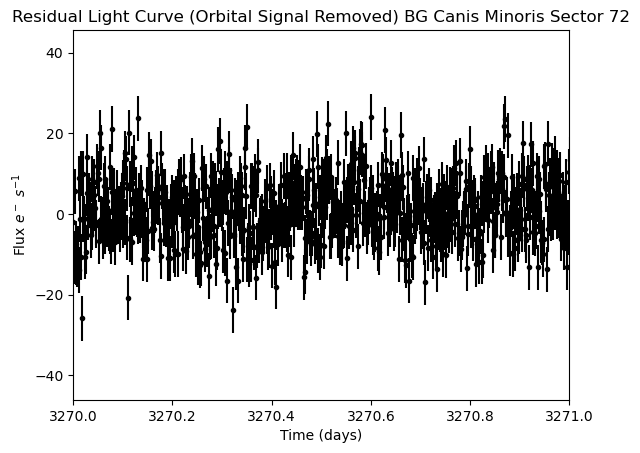

In [57]:
plt.errorbar(time4, residual4, yerr=flux_error4, fmt='k.')
plt.xlim(3270,3271)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

(-5.0, 200.0)

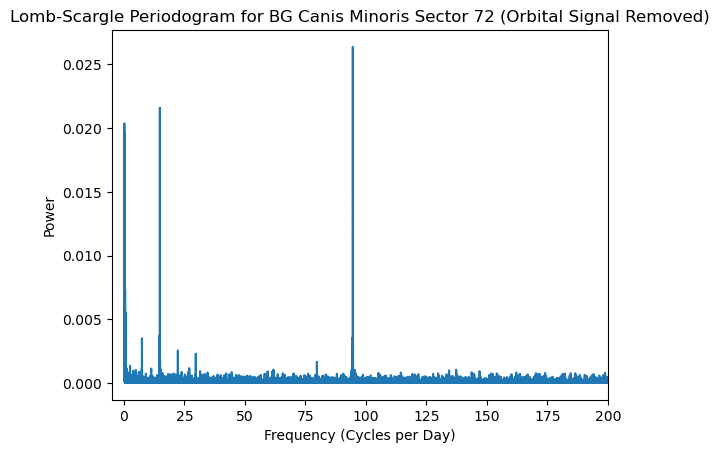

In [58]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies42 = np.linspace(min_freq, max_freq, 1000000) 

power42 = LombScargle(time4, residual4).power(frequencies42)

plt.plot(frequencies42, power42)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.229e+00  9.266e-01 ... -1.116e+00  3.887e-01]
           x: [-1.953e+00  9.459e+01  5.292e-01]
        cost: 15391.359008304524
         jac: [[ 1.581e-01  1.571e+03  4.817e-01]
               [ 7.837e-02  5.716e+03  1.752e+00]
               ...
               [ 1.439e-01 -4.253e+03 -1.295e+00]
               [ 1.757e-01  1.382e+03  4.207e-01]]
        grad: [ 3.682e-05  8.638e+02  2.635e-01]
  optimality: 863.8372662592155
 active_mask: [0 0 0]
        nfev: 6
        njev: 5
   param_cov: [[ 4.595e-03  4.014e-09 -1.325e-05]
               [ 4.014e-09  6.027e-07 -1.973e-03]
               [-1.325e-05 -1.973e-03  6.461e+00]]
2.2041184316632574
[[ 1.01287715e-02  8.84734138e-09 -2.91943730e-05]
 [ 8.84734138e-09  1.32847743e-06 -4.34965963e-03]
 [-2.91943730e-05 -4.34965963e-03  1.42415881e+01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [-1.95266759 9

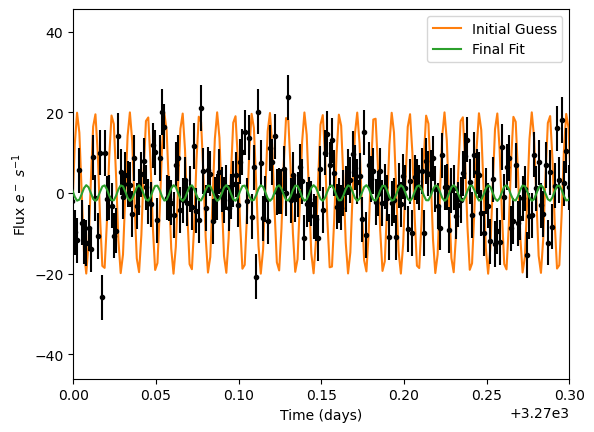

In [59]:
sine41 = models.Sine1D(amplitude=20, frequency=94.58624350737058, phase=0)
sine42 = models.Sine1D(amplitude=1, frequency=94.58624350737058-2*7.42092493092493, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin4 = sine41 #+ sine42

def tie_freq(model):
    return model.frequency_0 - 2*7.42092493092493

sine42.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine42.phase.tied = tie_phase

sin_final_spin4 = fit_sin(sin_init_spin4, time4, residual4, weights=1/flux_error4, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin4 = np.sum(((sin_final_spin4(time4)-residual4)/flux_error4)**2)
chi2_r_spin4 = chi2_spin4/(len(time4)-3)
print(chi2_r_spin4)

pfit_spin4 = fit_sin.fit_info.x
pcov_spin4 = fit_sin.fit_info.param_cov * chi2_r_spin4
print(pcov_spin4)
error_spin4 = []

for i in range(len(pfit_spin4)):
    error_spin4.append(np.absolute(pcov_spin4[i][i])**0.5)
        
perr_leastsq_spin4 = np.array(error_spin4) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin4)
print("perr = \ ", perr_leastsq_spin4)

plt.errorbar(time4, residual4, flux_error4, fmt='k.', zorder=2),
plt.plot(time4, sin_init_spin4(time4),'C1', label='Initial Guess', zorder=1)
plt.plot(time4, sin_final_spin4(time4),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3270, 3270.3)
plt.show()

In [60]:
pspin4_model = 1/pfit_spin4[1]
pspin4_models = pspin4_model*u.day.to(u.s)

pspin4_model_error = (1/pfit_spin4[1])*(perr_leastsq_spin4[1])
pspin4_model_errors = pspin4_model_error*u.day.to(u.s)

print(pspin4_models)
print(pspin4_model_errors)

913.4537004459874
1.0528430384368728


## BG Canis Minoris 5

In [61]:
lc5 = np.genfromtxt("bgcmi5.csv", delimiter=",")
time5 = lc5[0]
flux5 = lc5[1]
flux_error5 = lc5[2]

(1495.0, 1496.0)

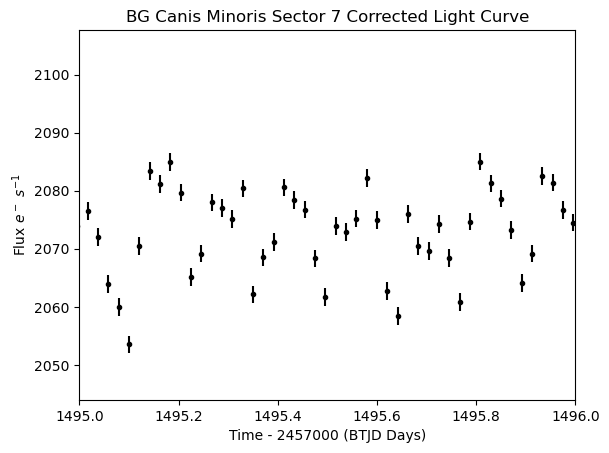

In [62]:
plt.errorbar(time5, flux5, yerr=flux_error5, fmt='k.')
plt.title('BG Canis Minoris Sector 7 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(1495, 1496)

## BG Canis Minoris 6

In [63]:
lc6 = np.genfromtxt("bgcmi6.csv", delimiter=",")
time6 = lc6[0]
flux6 = lc6[1]
flux_error6 = lc6[2]

(3245.0, 3246.0)

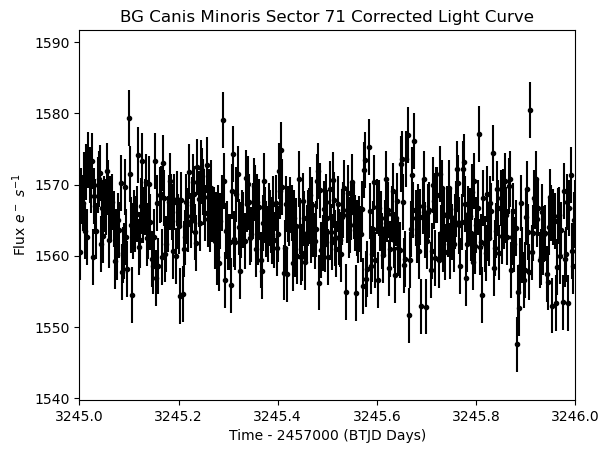

In [64]:
plt.errorbar(time6, flux6, yerr=flux_error6, fmt='k.')
plt.title('BG Canis Minoris Sector 71 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3245, 3246)

Text(189, 0.01, '2$\\omega$')

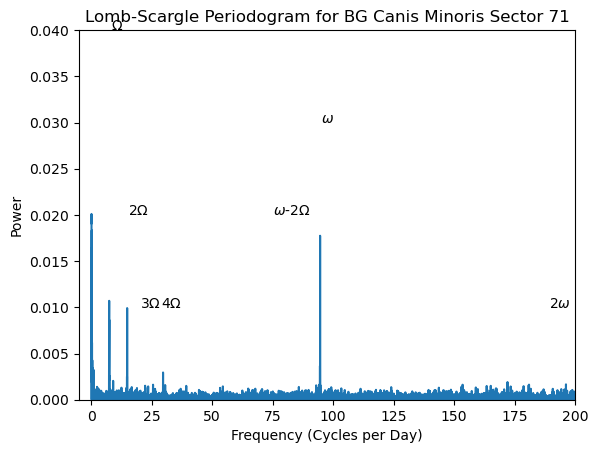

In [65]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies61 = np.linspace(min_freq, max_freq, 1000000) 

power61 = LombScargle(time6, flux6).power(frequencies61)

plt.plot(frequencies61, power61)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.ylim(0, 0.04)
plt.text(8, 0.04, '$\Omega$')
plt.text(95, 0.03, '$\omega$')
plt.text(15, 0.02, '2$\Omega$')
plt.text(20, 0.01, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [66]:
min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time6)))  # Nyquist frequency
frequencies62 = np.linspace(min_freq, max_freq, 1000000) 
power62 = LombScargle(time6, flux6).power(frequencies62)


fspin6 = frequencies62[np.argmax(power62)]
print(fspin6)

pspin6 = 1/fspin6
pspin6s = pspin6*u.day.to(u.s)
print(pspin6s)

min_freq = 1  # Lower bound of frequencies
max_freq = 50
frequencies63 = np.linspace(min_freq, max_freq, 1000000) 
power63 = LombScargle(time6, flux6).power(frequencies63)

forb6 = frequencies63[np.argmax(power63)]
print(forb6)

porb6 = 1/forb6
porb6h = porb6*u.day.to(u.hour)
print(porb6h)

94.58586816235706
913.4556956404314
7.4145964145964145
3.2368585770566654


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

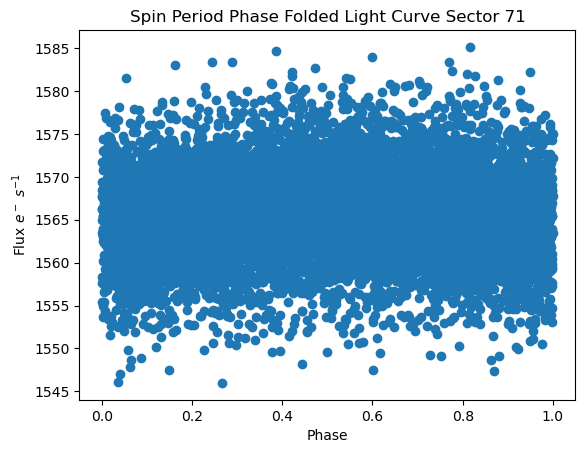

In [67]:
t6 = time6[0]

# Compute cycle number
n6 = (time6 - t6) / pspin6

# Compute new x-axis (integer cycles + phase)
spin_folded6 = (n6 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded6)
spin_folded_sorted6 = spin_folded6[sorted_indices]
spin_flux_sorted6 = flux6[sorted_indices]

plt.scatter(spin_folded_sorted6, spin_flux_sorted6)
plt.title('Spin Period Phase Folded Light Curve Sector 71')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.720e+00  1.599e+00 ... -1.327e+00 -2.357e-01]
           x: [-3.629e-02  7.416e+00  1.267e-01 -5.099e-01  1.566e+03]
        cost: 8143.761814689641
         jac: [[ 6.536e-02 -2.387e+03 ...  4.980e-02  2.358e-01]
               [ 4.065e-02 -2.212e+03 ...  9.817e-02  2.363e-01]
               ...
               [-2.011e-03 -1.674e+03 ...  1.689e-01  2.375e-01]
               [-2.754e-02 -1.236e+03 ...  2.005e-01  2.372e-01]]
        grad: [ 2.589e+01  5.624e+05  1.552e+02  5.387e+01  6.008e-01]
  optimality: 562423.6955654498
 active_mask: [0 0 0 0 0]
        nfev: 35
        njev: None
   param_cov: [[ 3.574e-03 -3.461e-08 ... -1.970e-06 -7.413e-06]
               [-3.461e-08  1.831e-07 ... -4.803e-08 -3.931e-08]
               ...
               [-1.970e-06 -4.803e-08 ...  3.567e-03 -7.055e-06]
               [-7.413e-06 -3.931e-08 ... -7.055e-06  1.784e-03]]
1.89455898911007

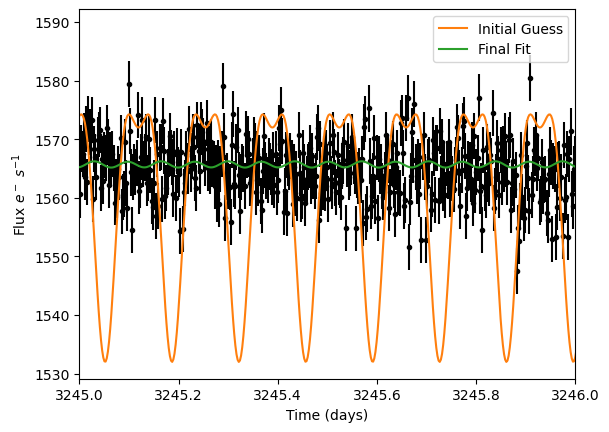

In [68]:
sine61 = models.Sine1D(amplitude=20, frequency=7.4145964145964145, phase=0)
sine62 = models.Sine1D(amplitude=8, frequency=2*7.4145964145964145, phase=0.25)
constant6 = models.Const1D(amplitude=1560)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb6 = sine61 + sine62 + constant6

def tie_freq(model):
    return model.frequency_0 * 2

sine62.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine62.phase.tied = tie_phase

sin_final_orb6 = fit_sin(sin_init_orb6, time6, flux6, weights=1/flux_error6, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb6 = np.sum(((sin_final_orb6(time6)-flux6)/flux_error6)**2)
chi2_r_orb6 = chi2_orb6/(len(time6)-3)
print(chi2_r_orb6)

pfit_orb6 = fit_sin.fit_info.x
pcov_orb6 = fit_sin.fit_info.param_cov * chi2_r_orb6
print(pcov_orb6)
error_orb6 = []

for i in range(len(pfit_orb6)):
    error_orb6.append(np.absolute(pcov_orb6[i][i])**0.5)
        
perr_leastsq_orb6 = np.array(error_orb6) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb6)
print("perr = \ ", perr_leastsq_orb6)

plt.errorbar(time6, flux6, flux_error6, fmt='k.', zorder=1),
plt.plot(time6, sin_init_orb6(time6),'C1', label='Initial Guess', zorder=2)
plt.plot(time6, sin_final_orb6(time6),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3245,3246)
plt.legend()
plt.show()

In [69]:
residual6 = flux6-sin_final_orb6(time6)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

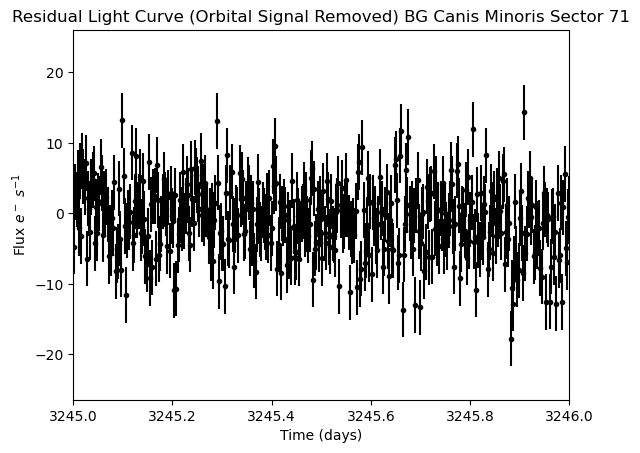

In [70]:
plt.errorbar(time6, residual6, yerr=flux_error6, fmt='k.')
plt.xlim(3245,3246)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 71')

(-5.0, 200.0)

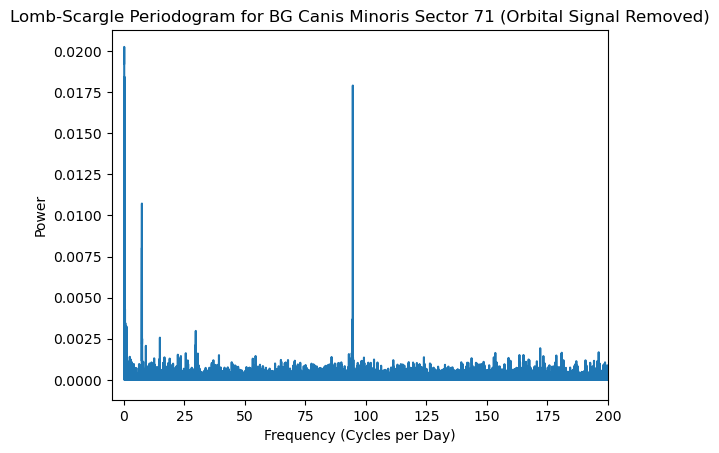

In [71]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies62 = np.linspace(min_freq, max_freq, 1000000) 

power62 = LombScargle(time6, residual6).power(frequencies62)

plt.plot(frequencies62, power62)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 71 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.499e+00  1.464e+00 ... -1.160e+00 -3.751e-01]
           x: [-1.018e+00  9.459e+01  1.897e-01]
        cost: 7998.516188386719
         jac: [[ 2.170e-01 -1.912e+03 -5.907e-01]
               [ 1.329e-01  4.043e+03  1.249e+00]
               ...
               [-1.637e-01 -3.586e+03 -1.100e+00]
               [ 1.369e-01 -4.039e+03 -1.239e+00]]
        grad: [ 3.383e-06  4.494e+01  1.378e-02]
  optimality: 44.942194812381786
 active_mask: [0 0 0]
        nfev: 5
        njev: 4
   param_cov: [[ 3.567e-03  2.822e-08 -9.144e-05]
               [ 2.822e-08  1.644e-06 -5.338e-03]
               [-9.144e-05 -5.338e-03  1.734e+01]]
1.8607691493280722
[[ 6.63801683e-03  5.25035240e-08 -1.70155568e-04]
 [ 5.25035240e-08  3.05857319e-06 -9.93330050e-03]
 [-1.70155568e-04 -9.93330050e-03  3.22604525e+01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [-1.01798035 9

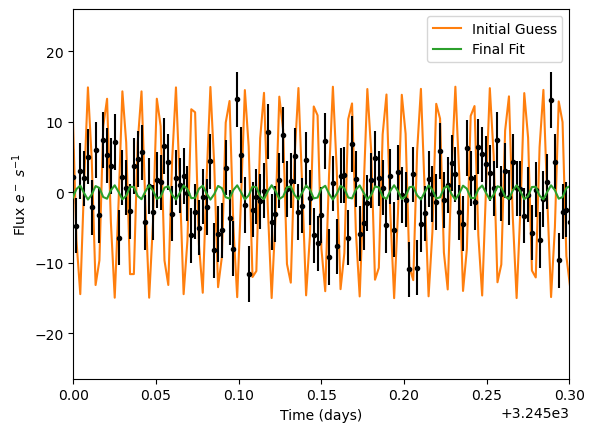

In [72]:
sine61 = models.Sine1D(amplitude=15, frequency=94.58586816235706, phase=0.25)
sine62 = models.Sine1D(amplitude=1, frequency=94.58586816235706-2*7.4145964145964145, phase=0.5)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin6 = sine61 #+ sine62

def tie_freq(model):
    return model.frequency_0 - 2*7.4145964145964145

sine62.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine62.phase.tied = tie_phase

sin_final_spin6 = fit_sin(sin_init_spin6, time6, residual6, weights=1/flux_error6, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin6 = np.sum(((sin_final_spin6(time6)-residual6)/flux_error6)**2)
chi2_r_spin6 = chi2_spin6/(len(time6)-3)
print(chi2_r_spin6)

pfit_spin6 = fit_sin.fit_info.x
pcov_spin6 = fit_sin.fit_info.param_cov * chi2_r_spin6
print(pcov_spin6)
error_spin6 = []

for i in range(len(pfit_spin6)):
    error_spin6.append(np.absolute(pcov_spin6[i][i])**0.5)
        
perr_leastsq_spin6 = np.array(error_spin6) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin6)
print("perr = \ ", perr_leastsq_spin6)

plt.errorbar(time6, residual6, flux_error6, fmt='k.', zorder=2),
plt.plot(time6, sin_init_spin6(time6),'C1', label='Initial Guess', zorder=1)
plt.plot(time6, sin_final_spin6(time6),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3245, 3245.3)
plt.show()

In [73]:
pspin6_model = 1/pfit_spin6[1]
pspin6_models = pspin6_model*u.day.to(u.s)

pspin6_model_error = (1/pfit_spin6[1])*(perr_leastsq_spin6[1])
pspin6_model_errors = pspin6_model_error*u.day.to(u.s)

print(pspin6_models)
print(pspin6_model_errors)

913.455505818491
1.5975219599994177


## BG Canis Minoris 7

In [74]:
lc7 = np.genfromtxt("bgcmi7.csv", delimiter=",")
time7 = lc7[0]
flux7 = lc7[1]
flux_error7 = lc7[2]

(3270.0, 3271.0)

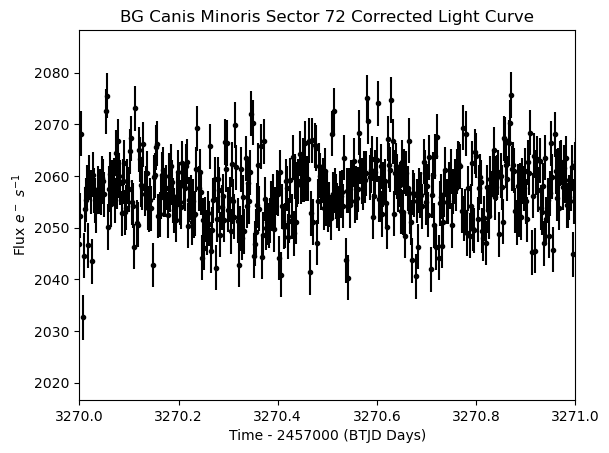

In [75]:
plt.errorbar(time7, flux7, yerr=flux_error7, fmt='k.')
plt.title('BG Canis Minoris Sector 72 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3270, 3271)

Text(189, 0.01, '2$\\omega$')

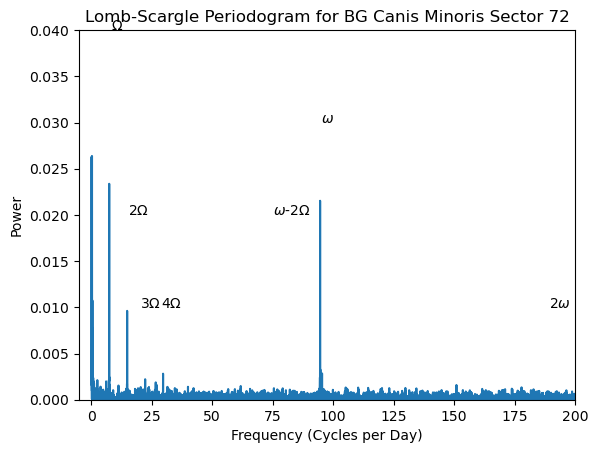

In [76]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies71 = np.linspace(min_freq, max_freq, 1000000) 

power71 = LombScargle(time7, flux7).power(frequencies71)

plt.plot(frequencies71, power71)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.ylim(0, 0.04)
plt.text(8, 0.04, '$\Omega$')
plt.text(95, 0.03, '$\omega$')
plt.text(15, 0.02, '2$\Omega$')
plt.text(20, 0.01, '3$\Omega$')
plt.text(29, 0.01, '4$\Omega$')
plt.text(75, 0.02, '$\omega$-2$\Omega$')
plt.text(189, 0.01,'2$\omega$' )

In [77]:
min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time7)))  # Nyquist frequency
frequencies72 = np.linspace(min_freq, max_freq, 1000000) 
power72 = LombScargle(time7, flux7).power(frequencies72)

fspin7 = frequencies72[np.argmax(power72)]
print(fspin7)

pspin7 = 1/fspin7
pspin7s = pspin7*u.day.to(u.s)
print(pspin7s)

min_freq = 1  # Lower bound of frequencies
max_freq = 50
frequencies73 = np.linspace(min_freq, max_freq, 1000000) 
power73 = LombScargle(time7, flux7).power(frequencies73)

forb7 = frequencies73[np.argmax(power73)]
print(forb7)

porb7 = 1/forb7
porb7h = porb7*u.day.to(u.hour)
print(porb7h)

94.58749980134463
913.4399384851038
7.420819420819421
3.234144187994522


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

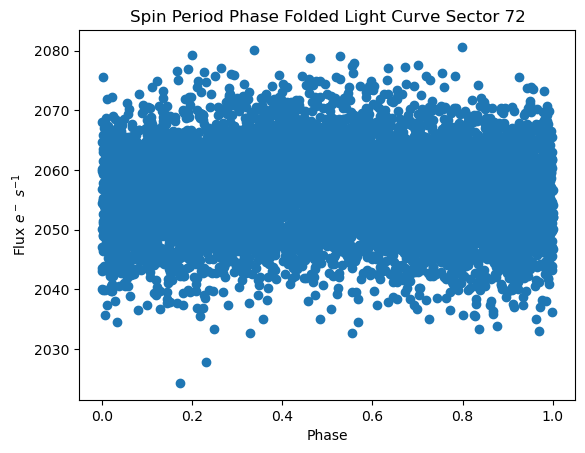

In [78]:
t7 = time7[0]

# Compute cycle number
n7 = (time7 - t7) / pspin7

# Compute new x-axis (integer cycles + phase)
spin_folded7 = (n7 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded7)
spin_folded_sorted7 = spin_folded7[sorted_indices]
spin_flux_sorted7 = flux7[sorted_indices]

plt.scatter(spin_folded_sorted7, spin_flux_sorted7)
plt.title('Spin Period Phase Folded Light Curve Sector 72')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.683e-02 -5.216e-01 ... -7.202e-01 -1.786e-01]
           x: [-1.138e+00  7.427e+00  4.629e-01 -7.200e-01  2.056e+03]
        cost: 10247.08159945147
         jac: [[-1.805e-01 -2.487e+02 ...  1.397e-01  2.103e-01]
               [-1.912e-01 -1.358e+02 ...  1.702e-01  2.104e-01]
               ...
               [ 3.384e-02 -6.396e+03 ... -1.989e-01  2.303e-01]
               [ 5.833e-02 -6.924e+03 ... -1.698e-01  2.308e-01]]
        grad: [ 6.863e+01  1.394e+06  3.861e+02 -2.197e+01  9.080e-01]
  optimality: 1394259.9038245906
 active_mask: [0 0 0 0 0]
        nfev: 46
        njev: None
   param_cov: [[ 4.590e-03  4.250e-09 ... -8.111e-06 -7.567e-06]
               [ 4.250e-09  9.519e-10 ...  4.614e-10 -4.809e-09]
               ...
               [-8.111e-06  4.614e-10 ...  4.590e-03  8.347e-07]
               [-7.567e-06 -4.809e-09 ...  8.347e-07  2.295e-03]]
2.4456042003464

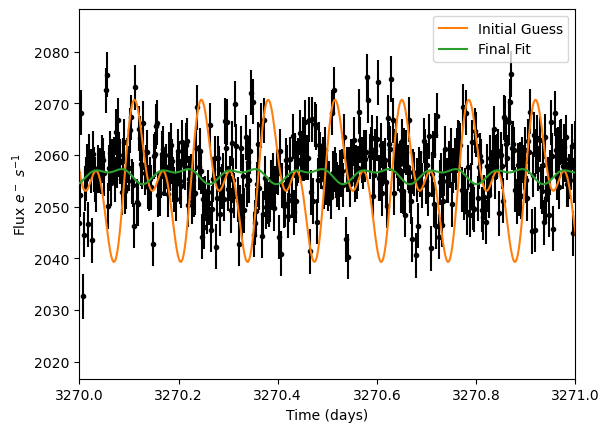

In [79]:
sine71 = models.Sine1D(amplitude=10, frequency=7.420819420819421, phase=0.25)
sine72 = models.Sine1D(amplitude=8, frequency=2*7.420819420819421, phase=0.5)
constant7 = models.Const1D(amplitude=2055)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb7 = sine71 + sine72 + constant7

def tie_freq(model):
    return model.frequency_0 * 2

sine72.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine72.phase.tied = tie_phase

sin_final_orb7 = fit_sin(sin_init_orb7, time7, flux7, weights=1/flux_error7, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb7 = np.sum(((sin_final_orb7(time7)-flux7)/flux_error7)**2)
chi2_r_orb7 = chi2_orb7/(len(time7)-3)
print(chi2_r_orb7)

pfit_orb7 = fit_sin.fit_info.x
pcov_orb7 = fit_sin.fit_info.param_cov * chi2_r_orb7
print(pcov_orb7)
error_orb7 = []

for i in range(len(pfit_orb7)):
    error_orb7.append(np.absolute(pcov_orb7[i][i])**0.5)
        
perr_leastsq_orb7 = np.array(error_orb7) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb7)
print("perr = \ ", perr_leastsq_orb7)

plt.errorbar(time7, flux7, flux_error7, fmt='k.', zorder=1),
plt.plot(time7, sin_init_orb7(time7),'C1', label='Initial Guess', zorder=2)
plt.plot(time7, sin_final_orb7(time7),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3270,3271)
plt.legend()
plt.show()

In [80]:
residual7 = flux7-sin_final_orb7(time7)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

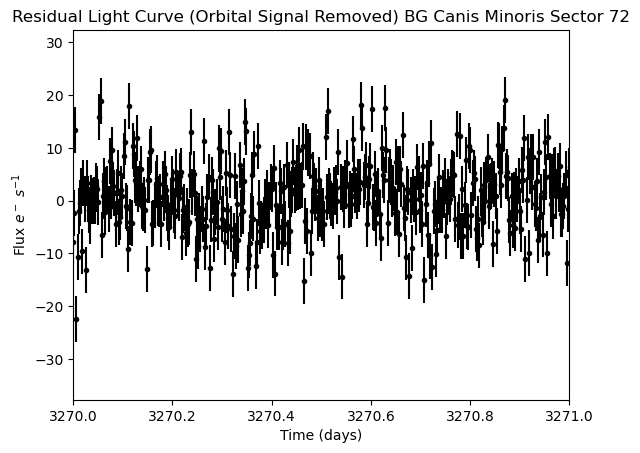

In [81]:
plt.errorbar(time7, residual7, yerr=flux_error7, fmt='k.')
plt.xlim(3270,3271)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) BG Canis Minoris Sector 72')

(-5.0, 200.0)

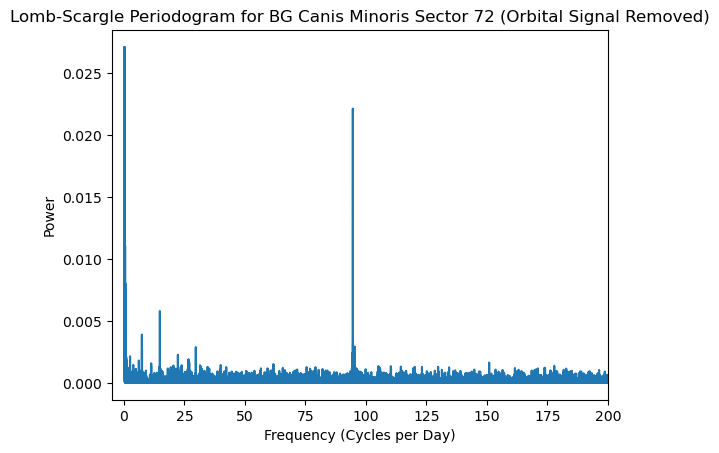

In [82]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies72 = np.linspace(min_freq, max_freq, 1000000) 

power72 = LombScargle(time7, residual7).power(frequencies72)

plt.plot(frequencies72, power72)
plt.title('Lomb-Scargle Periodogram for BG Canis Minoris Sector 72 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.088e-01 -4.997e-01 ... -8.287e-01 -5.076e-01]
           x: [-1.439e+00  9.459e+01  8.158e-02]
        cost: 10021.474152657147
         jac: [[ 2.028e-01  1.641e+03  5.029e-01]
               [-1.527e-02  6.191e+03  1.898e+00]
               ...
               [ 7.536e-02 -6.465e+03 -1.968e+00]
               [ 2.286e-01  9.460e+02  2.879e-01]]
        grad: [ 5.329e-07  3.511e+01  1.074e-02]
  optimality: 35.11471491493285
 active_mask: [0 0 0]
        nfev: 8
        njev: 7
   param_cov: [[ 4.591e-03 -1.039e-08  3.392e-05]
               [-1.039e-08  1.109e-06 -3.630e-03]
               [ 3.392e-05 -3.630e-03  1.188e+01]]
2.3917599409682926
[[ 1.09797764e-02 -2.48498902e-08  8.11243291e-05]
 [-2.48498902e-08  2.65158773e-06 -8.68174417e-03]
 [ 8.11243291e-05 -8.68174417e-03  2.84256248e+01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [-1.43922818e+

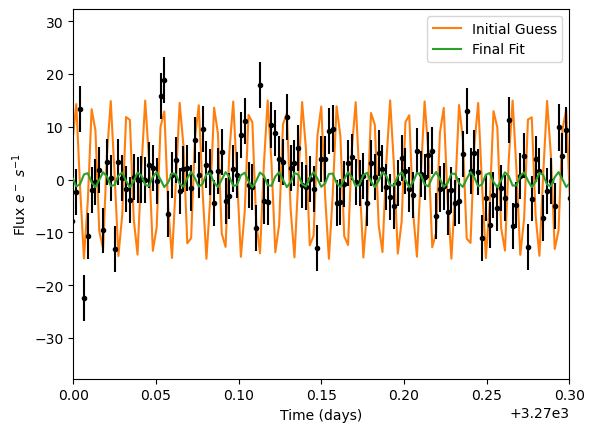

In [83]:
sine71 = models.Sine1D(amplitude=15, frequency=94.58749980134463, phase=0)
sine72 = models.Sine1D(amplitude=1, frequency=94.58749980134463-2*7.420819420819421, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin7 = sine71 #+ sine72

def tie_freq(model):
    return model.frequency_0 - 2*7.420819420819421

sine72.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine72.phase.tied = tie_phase

sin_final_spin7 = fit_sin(sin_init_spin7, time7, residual7, weights=1/flux_error7, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin7 = np.sum(((sin_final_spin7(time7)-residual7)/flux_error7)**2)
chi2_r_spin7 = chi2_spin7/(len(time7)-3)
print(chi2_r_spin7)

pfit_spin7 = fit_sin.fit_info.x
pcov_spin7 = fit_sin.fit_info.param_cov * chi2_r_spin7
print(pcov_spin7)
error_spin7 = []

for i in range(len(pfit_spin7)):
    error_spin7.append(np.absolute(pcov_spin7[i][i])**0.5)
        
perr_leastsq_spin7 = np.array(error_spin7) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin7)
print("perr = \ ", perr_leastsq_spin7)

plt.errorbar(time7, residual7, flux_error7, fmt='k.', zorder=2),
plt.plot(time7, sin_init_spin7(time7),'C1', label='Initial Guess', zorder=1)
plt.plot(time7, sin_final_spin7(time7),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3270, 3270.3)
plt.show()

In [84]:
pspin7_model = 1/pfit_spin7[1]
pspin7_models = pspin7_model*u.day.to(u.s)

pspin7_model_error = (1/pfit_spin7[1])*(perr_leastsq_spin7[1])
pspin7_model_errors = pspin7_model_error*u.day.to(u.s)

print(pspin7_models)
print(pspin7_model_errors)

913.4405242921158
1.4874188303427407


In [85]:
data.loc["Orbital Frequency (days⁻¹)", :] = [forb0, forb1, forb2, forb3, forb4, np.nan, forb6, forb7]
data.loc["Orbital Period (hours)", :] = [porb0h, porb1h, porb2h, porb3h, porb4h, np.nan, porb6h, porb7h]
data.loc["Spin Frequency (days⁻¹)", :] = [fspin0, fspin1, fspin2, fspin3, fspin4, np.nan, fspin6, fspin7]
data.loc["Spin Period (seconds)", :] = [pspin0s, pspin1s, pspin2s, pspin3s, pspin4s, np.nan, pspin6s, pspin7s]
data.loc["Model Spin Period (seconds)", :] = [pspin0_models, pspin1_models, pspin2_models, pspin3_models , pspin4_models, np.nan, pspin6_models, pspin7_models]
data.loc["Model Spin Period Error (seconds)", :] = [pspin0_model_errors, pspin1_model_errors, pspin2_model_errors, pspin3_model_errors, pspin4_model_errors, np.nan, pspin6_model_errors, pspin7_model_errors]
data.loc["Model Spin Period Reduced χ2", :] = [chi2_r_spin0, chi2_r_spin1, chi2_r_spin2, chi2_r_spin3, chi2_r_spin4, np.nan, chi2_r_spin6, chi2_r_spin7]
print(data)

                                   0: Sector7  1: Sector71  2: Sector72  \
Orbital Frequency (days⁻¹)           7.421540     7.421372     7.421527   
Orbital Period (hours)               3.233830     3.233903     3.233836   
Spin Frequency (days⁻¹)             94.584856    94.584580    94.585009   
Spin Period (seconds)              913.465467   913.468138   913.463996   
Model Spin Period (seconds)        913.459129   913.458772   913.456633   
Model Spin Period Error (seconds)    1.915439     0.260000     0.225109   
Model Spin Period Reduced χ2         4.262818     1.959643     1.703528   

                                   3: Sector71  4: Sector72  5: Sector7  \
Orbital Frequency (days⁻¹)            7.421062     7.420925         NaN   
Orbital Period (hours)                3.234038     3.234098         NaN   
Spin Frequency (days⁻¹)              94.584634    94.586244         NaN   
Spin Period (seconds)               913.467615   913.452071         NaN   
Model Spin Period (secon

In [86]:
data.to_csv("BGCMi_Spin_Periods.csv")